Inspect missing values:


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


,Open,High,Low,Close,Volume,Adj Close
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681


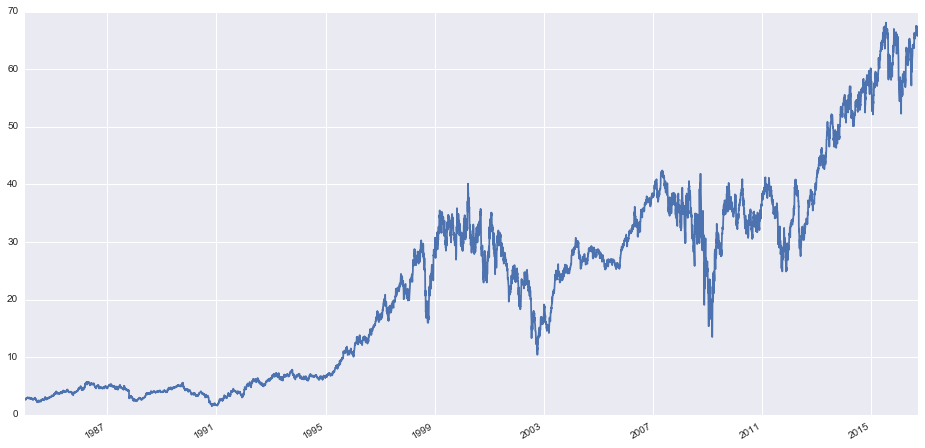

In [43]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random

pd.set_option('display.max_columns', 50)

# dfSPY = pd.read_csv('allSPY.csv', index_col='Date', parse_dates=True, na_values = ['nan'])
dfJPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True, na_values = ['nan'])

# del dfSPY.index.name
del dfJPM.index.name
# display(dfSPY)

start_date = '1983-12-30'
end_date = '2016-09-27'

dates = pd.date_range(start_date, end_date)

dfMain = pd.DataFrame(index=dates)
# dfMain = dfMain.join(dfSPY)
dfMain = dfMain.join(dfJPM)
dfMain.dropna(inplace=True)

print("Inspect missing values:")
display(dfMain.isnull().sum())
display(dfMain.head())

# Adjust Open, High, Low, Volume
dfMain['Adj Factor'] = dfMain['Adj Close'] / dfMain['Close']

dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']

dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

dfMain.drop(['Adj Factor'], axis=1, inplace=True)
display(dfMain.head())

# Price Engineering
# Get opens
dfMain['-1d_Open'] = dfMain['Open'].shift()
dfMain['-2d_Open'] = dfMain['Open'].shift(2)
dfMain['-3d_Open'] = dfMain['Open'].shift(3)
dfMain['-4d_Open'] = dfMain['Open'].shift(4)
dfMain['-5d_Open'] = dfMain['Open'].shift(5)
dfMain['-10d_Open'] = dfMain['Open'].shift(10)
dfMain['-21d_Open'] = dfMain['Open'].shift(21)
dfMain['-63d_Open'] = dfMain['Open'].shift(63)
dfMain['-100d_Open'] = dfMain['Open'].shift(100)

# Get adjCloses
dfMain['-1d_adjClose'] = dfMain['Adj Close'].shift()
dfMain['-2d_adjClose'] = dfMain['Adj Close'].shift(2)
dfMain['-3d_adjClose'] = dfMain['Adj Close'].shift(3)
dfMain['-4d_adjClose'] = dfMain['Adj Close'].shift(4)
dfMain['-5d_adjClose'] = dfMain['Adj Close'].shift(5)

# Get highs
dfMain['-1d_High'] = dfMain['High'].shift()
dfMain['-2d_High'] = dfMain['High'].shift(2)
dfMain['-3d_High'] = dfMain['High'].shift(3)
dfMain['-4d_High'] = dfMain['High'].shift(4)
dfMain['-5d_High'] = dfMain['High'].shift(5)
dfMain['10d_High'] = dfMain['High'].shift().rolling(window=10).max()
dfMain['21d_High'] = dfMain['High'].shift().rolling(window=21).max()
dfMain['63d_High'] = dfMain['High'].shift().rolling(window=63).max()
dfMain['100d_High'] = dfMain['High'].shift().rolling(window=100).max()

# Get lows
dfMain['-1d_Low'] = dfMain['Low'].shift()
dfMain['-2d_Low'] = dfMain['Low'].shift(2)
dfMain['-3d_Low'] = dfMain['Low'].shift(3)
dfMain['-4d_Low'] = dfMain['Low'].shift(4)
dfMain['-5d_Low'] = dfMain['Low'].shift(5)
dfMain['10d_Low'] = dfMain['Low'].shift().rolling(window=10).min()
dfMain['21d_Low'] = dfMain['Low'].shift().rolling(window=21).min()
dfMain['63d_Low'] = dfMain['Low'].shift().rolling(window=63).min()
dfMain['100d_Low'] = dfMain['Low'].shift().rolling(window=100).min()

dfMain['Adj Close'].plot(figsize=(16, 8))
# display(dfMain)

In [44]:
dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

dfMain['Abs_Spread'] = np.abs(dfMain['Close'] - dfMain['Open'])
dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()

dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain.tail(20))
display(dfMain.ix[datetime(2011, 12, 30)][['Open', 'Adj Close']])

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low,100d_Avg_Vol,100d_Max_Vol,100d_Avg_Spread,100d_Max_Spread
2016-08-30,66.949997,67.599998,66.949997,67.500000,13791200.0,67.500000,66.489998,66.330002,65.910004,65.989998,66.070000,65.360001,64.150002,64.259766,57.264220,66.949997,66.220001,66.070000,65.949997,65.769997,67.099998,66.879997,66.139999,66.230003,66.339996,67.099998,67.099998,67.099998,67.099998,66.459999,65.849998,65.790001,65.769997,65.760002,65.220001,63.380001,56.609318,56.609318,2.216008e+07,4.445207e+07,0.807761,10.490680
2016-08-31,67.459999,67.769997,66.860001,67.500000,14952300.0,67.500000,66.949997,66.489998,66.330002,65.910004,65.989998,65.800003,63.590000,65.013890,57.462676,67.500000,66.949997,66.220001,66.070000,65.949997,67.599998,67.099998,66.879997,66.139999,66.230003,67.599998,67.599998,67.599998,67.599998,66.949997,66.459999,65.849998,65.790001,65.769997,65.220001,63.380001,56.609318,56.609318,2.216215e+07,4.445207e+07,0.808874,10.990680
2016-09-01,67.639999,67.720001,66.650002,67.209999,12226500.0,67.209999,67.459999,66.949997,66.489998,66.330002,65.910004,65.620003,63.689999,63.753704,57.889355,67.500000,67.500000,66.949997,66.220001,66.070000,67.769997,67.599998,67.099998,66.879997,66.139999,67.769997,67.769997,67.769997,67.769997,66.860001,66.949997,66.459999,65.849998,65.790001,65.220001,63.650002,56.609318,56.609318,2.211996e+07,4.445207e+07,0.798414,11.160679
2016-09-02,67.400002,67.580002,66.980003,67.489998,13720700.0,67.489998,67.639999,67.459999,66.949997,66.489998,66.330002,65.720001,64.489998,64.140690,60.012824,67.209999,67.500000,67.500000,66.949997,66.220001,67.720001,67.769997,67.599998,67.099998,66.879997,67.769997,67.769997,67.769997,67.769997,66.650002,66.860001,66.949997,66.459999,65.849998,65.220001,64.269997,56.609318,56.609318,2.203459e+07,4.445207e+07,0.784005,11.160679
2016-09-06,67.500000,67.550003,66.709999,67.440002,16649400.0,67.440002,67.400002,67.639999,67.459999,66.949997,66.489998,65.750000,65.139999,64.944430,61.213477,67.489998,67.209999,67.500000,67.500000,66.949997,67.580002,67.720001,67.769997,67.599998,67.099998,67.769997,67.769997,67.769997,67.769997,66.980003,66.650002,66.860001,66.949997,66.459999,65.410004,64.860001,56.609318,56.609318,2.167327e+07,4.445207e+07,0.758697,11.160679
2016-09-07,67.160004,67.589996,66.959999,67.160004,10070400.0,67.160004,67.500000,67.400002,67.639999,67.459999,66.949997,66.070000,66.070000,64.428451,62.394286,67.440002,67.489998,67.209999,67.500000,67.500000,67.550003,67.580002,67.720001,67.769997,67.599998,67.769997,67.769997,67.769997,67.769997,66.709999,66.980003,66.650002,66.860001,66.949997,65.760002,64.860001,56.609318,56.609318,2.155643e+07,4.445207e+07,0.738949,11.160679
2016-09-08,67.220001,67.680000,67.000000,67.250000,12253000.0,67.250000,67.160004,67.500000,67.400002,67.639999,67.459999,65.989998,66.180000,64.289533,61.163863,67.160004,67.440002,67.489998,67.209999,67.500000,67.589996,67.550003,67.580002,67.720001,67.769997,67.769997,67.769997,67.769997,67.769997,66.959999,66.709999,66.980003,66.650002,66.860001,65.769997,64.860001,56.609318,56.609318,2.141587e+07,4.445207e+07,0.731085,11.160679
2016-09-09,67.029999,67.430000,66.639999,66.650002,19686900.0,66.650002,67.220001,67.160004,67.500000,67.400002,67.639999,65.910004,65.919998,63.436175,62.066834,67.250000,67.160004,67.440002,67.489998,67.209999,67.680000,67.589996,67.550003,67.580002,67.720001,67.769997,67.769997,67.769997,67.769997,67.000000,66.959999,66.709999,66.980003,66.650002,65.790001,64.860001,56.609318,56.609318,2.139086e+07,4.445207e+07,0.714943,11.160679
2016-09-12,66.139999,67.300003,65.760002,67.059998,16453000.0,67.059998,67.029999,67.220001,67.160004,

Open         29.013163
Adj Close    29.135839
Name: 2011-12-30 00:00:00, dtype: float64

In [45]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

# def relative_transform(num):
#     if 0 <= num < 0.25:
#         return "Very Low"
#     elif 0.25 <= num < 0.5:
#         return "Low"
#     elif 0.5 <= num < 0.75:
#         return "Average"
#     elif 0.75 <= num < 1:
#         return "High"
#     elif 1 <= num:
#         return "Very High"
#     elif -0.25 <= num < 0:
#         return "N-Very Low"
#     elif -0.5 <= num < -0.25:
#         return "N-Low"
#     elif -0.75 <= num < -0.5:
#         return "N-Average"
#     elif -1 <= num < -0.75:
#         return "N-High"
#     elif num < -1:
#         return "N-Very High"
#     else:
#         num

# Volume Engineering
# Get volumes
dfMain['-1d_Vol'] = dfMain['Volume'].shift()
dfMain['-2d_Vol'] = dfMain['Volume'].shift(2)
dfMain['-3d_Vol'] = dfMain['Volume'].shift(3)
dfMain['-4d_Vol'] = dfMain['Volume'].shift(4)
dfMain['-5d_Vol'] = dfMain['Volume'].shift(5)

# Get avg. volumes
dfMain['10d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=10).mean()
dfMain['21d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=21).mean()
dfMain['63d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=63).mean()

# Get relative volumes 1
dfMain['-1d_Vol1'] = dfMain['-1d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-2d_Vol1'] = dfMain['-2d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-3d_Vol1'] = dfMain['-3d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-4d_Vol1'] = dfMain['-4d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-5d_Vol1'] = dfMain['-5d_Vol'] / dfMain['100d_Avg_Vol']

dfMain['-1d_Vol1'] = dfMain['-1d_Vol1'].apply(relative_transform)
dfMain['-2d_Vol1'] = dfMain['-2d_Vol1'].apply(relative_transform)
dfMain['-3d_Vol1'] = dfMain['-3d_Vol1'].apply(relative_transform)
dfMain['-4d_Vol1'] = dfMain['-4d_Vol1'].apply(relative_transform)
dfMain['-5d_Vol1'] = dfMain['-5d_Vol1'].apply(relative_transform)

# Get relative avg. volumes 1 
dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol'] / dfMain['100d_Avg_Vol']

dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol1'].apply(relative_transform)
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol1'].apply(relative_transform)
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol1'].apply(relative_transform)

# Get relative volumes 2
dfMain['-1d_Vol2'] = dfMain['-1d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-2d_Vol2'] = dfMain['-2d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-3d_Vol2'] = dfMain['-3d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-4d_Vol2'] = dfMain['-4d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-5d_Vol2'] = dfMain['-5d_Vol'] / dfMain['100d_Max_Vol']

dfMain['-1d_Vol2'] = dfMain['-1d_Vol2'].apply(relative_transform)
dfMain['-2d_Vol2'] = dfMain['-2d_Vol2'].apply(relative_transform)
dfMain['-3d_Vol2'] = dfMain['-3d_Vol2'].apply(relative_transform)
dfMain['-4d_Vol2'] = dfMain['-4d_Vol2'].apply(relative_transform)
dfMain['-5d_Vol2'] = dfMain['-5d_Vol2'].apply(relative_transform)

display(dfMain[dfMain['-1d_Vol1'] == 5][['-1d_Vol1', '-1d_Vol2', '-2d_Vol1', '-2d_Vol2', '-3d_Vol1', '-3d_Vol2', '10d_Avg_Vol1']])
                      
# display(dfMain[['-1d_Vol1', '-1d_Vol2', '-2d_Vol1', '-2d_Vol2', '-3d_Vol1', '-3d_Vol2', '10d_Avg_Vol1']].tail(30))

,-1d_Vol1,-1d_Vol2,-2d_Vol1,-2d_Vol2,-3d_Vol1,-3d_Vol2,10d_Avg_Vol1
1984-05-25,5.0,5.0,2.0,1.0,1.0,1.0,5.0
1984-05-31,5.0,2.0,2.0,1.0,2.0,1.0,5.0
1984-06-04,5.0,1.0,3.0,1.0,5.0,2.0,5.0
1984-06-05,5.0,1.0,5.0,1.0,3.0,1.0,5.0
1984-06-06,5.0,5.0,4.0,1.0,5.0,1.0,5.0
1984-06-08,5.0,1.0,3.0,1.0,5.0,5.0,5.0
1984-06-11,5.0,1.0,5.0,1.0,3.0,1.0,5.0
1984-06-13,5.0,1.0,2.0,1.0,5.0,1.0,5.0
1984-07-02,5.0,1.0,2.0,1.0,1.0,1.0,2.0
1984-07-25,5.0,1.0,2.0,1.0,3.0,1.0,2.0


In [46]:
# Spread Engineering
# Get spread

dfMain['-1d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-1d_Open']
dfMain['-2d_Spread'] = dfMain['-2d_adjClose'] - dfMain['-2d_Open']
dfMain['-3d_Spread'] = dfMain['-3d_adjClose'] - dfMain['-3d_Open']
dfMain['-4d_Spread'] = dfMain['-4d_adjClose'] - dfMain['-4d_Open']
dfMain['-5d_Spread'] = dfMain['-5d_adjClose'] - dfMain['-5d_Open']

dfMain['10d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-10d_Open']
dfMain['21d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-21d_Open']
dfMain['63d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-63d_Open']

# Get relative spread
dfMain['-1d_Spread'] = dfMain['-1d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-2d_Spread'] = dfMain['-2d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-3d_Spread'] = dfMain['-3d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-4d_Spread'] = dfMain['-4d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-5d_Spread'] = dfMain['-5d_Spread'] / dfMain['100d_Avg_Spread']

dfMain['-1d_Spread'] = dfMain['-1d_Spread'].apply(relative_transform)
dfMain['-2d_Spread'] = dfMain['-2d_Spread'].apply(relative_transform)
dfMain['-3d_Spread'] = dfMain['-3d_Spread'].apply(relative_transform)
dfMain['-4d_Spread'] = dfMain['-4d_Spread'].apply(relative_transform)
dfMain['-5d_Spread'] = dfMain['-5d_Spread'].apply(relative_transform)

dfMain['10d_Spread'] = dfMain['10d_Spread'] / dfMain['100d_Max_Spread']
dfMain['21d_Spread'] = dfMain['21d_Spread'] / dfMain['100d_Max_Spread']
dfMain['63d_Spread'] = dfMain['63d_Spread'] / dfMain['100d_Max_Spread']

dfMain['10d_Spread'] = dfMain['10d_Spread'].apply(relative_transform)
dfMain['21d_Spread'] = dfMain['21d_Spread'].apply(relative_transform)
dfMain['63d_Spread'] = dfMain['63d_Spread'].apply(relative_transform)

display(dfMain[['-1d_Spread', '-2d_Spread', '-3d_Spread', '-4d_Spread', '-5d_Spread', '21d_Spread']].tail(100))
# display(dfMain[dfMain['63d_Spread'] < 0]['63d_Spread'])

,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,21d_Spread
2016-05-06,-1.0,-1.0,-1.0,1.0,1.0,1.0
2016-05-09,3.0,-1.0,-1.0,-1.0,1.0,2.0
2016-05-10,-1.0,3.0,-1.0,-1.0,-1.0,1.0
2016-05-11,2.0,-1.0,3.0,-2.0,-1.0,1.0
2016-05-12,-1.0,2.0,-1.0,3.0,-2.0,1.0
2016-05-13,-2.0,-1.0,2.0,-1.0,3.0,1.0
2016-05-16,-2.0,-2.0,-1.0,2.0,-1.0,-1.0
2016-05-17,2.0,-2.0,-2.0,-1.0,2.0,1.0
2016-05-18,1.0,2.0,-2.0,-2.0,-1.0,-1.0
2016-05-19,5.0,1.0,2.0,-2.0,-2.0,1.0


In [47]:
# Get wicks
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False
    
for index, row in dfMain.iterrows():
    dfMain.ix[index, '-1d_upperwick_bool'] = upperwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_High'])
    dfMain.ix[index, '-1d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_Low'])
    
    dfMain.ix[index, '-2d_upperwick_bool'] = upperwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_High'])
    dfMain.ix[index, '-2d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_Low'])
    
    dfMain.ix[index, '-3d_upperwick_bool'] = upperwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_High'])
    dfMain.ix[index, '-3d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_Low'])
    
    dfMain.ix[index, '-4d_upperwick_bool'] = upperwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_High'])
    dfMain.ix[index, '-4d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_Low'])
    
    dfMain.ix[index, '-5d_upperwick_bool'] = upperwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_High'])
    dfMain.ix[index, '-5d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_Low'])
    
    dfMain.ix[index, '10d_upperwick_bool'] = upperwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_High'])
    dfMain.ix[index, '10d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_Low'])
    
    dfMain.ix[index, '21d_upperwick_bool'] = upperwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_High'])
    dfMain.ix[index, '21d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_Low'])
    
    dfMain.ix[index, '63d_upperwick_bool'] = upperwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_High'])
    dfMain.ix[index, '63d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_Low'])
    
    dfMain.ix[index, '100d_upperwick_bool'] = upperwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_High'])
    dfMain.ix[index, '100d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_Low'])
    
# print(dfMain.head(20))

In [48]:
# Transform upper wicks
p_spread1d_up = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_upperwick_bool']
n_spread1d_up = dfMain['-1d_Spread'] < 0 & dfMain['-1d_upperwick_bool']
p_spread2d_up = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_upperwick_bool']
n_spread2d_up = dfMain['-2d_Spread'] < 0 & dfMain['-2d_upperwick_bool']
p_spread3d_up = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_upperwick_bool']
n_spread3d_up = dfMain['-3d_Spread'] < 0 & dfMain['-3d_upperwick_bool']
p_spread4d_up = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_upperwick_bool']
n_spread4d_up = dfMain['-4d_Spread'] < 0 & dfMain['-4d_upperwick_bool']
p_spread5d_up = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_upperwick_bool']
n_spread5d_up = dfMain['-5d_Spread'] < 0 & dfMain['-5d_upperwick_bool']
p_spread10d_up = dfMain['10d_Spread'] >= 0 & dfMain['10d_upperwick_bool']
n_spread10d_up = dfMain['10d_Spread'] < 0 & dfMain['10d_upperwick_bool']
p_spread21d_up = dfMain['21d_Spread'] >= 0 & dfMain['21d_upperwick_bool']
n_spread21d_up = dfMain['21d_Spread'] < 0 & dfMain['21d_upperwick_bool']
p_spread63d_up = dfMain['63d_Spread'] >= 0 & dfMain['63d_upperwick_bool']
n_spread63d_up = dfMain['63d_Spread'] < 0 & dfMain['63d_upperwick_bool']

false1d_up = np.logical_not(dfMain['-1d_upperwick_bool'])
false2d_up = np.logical_not(dfMain['-2d_upperwick_bool'])
false3d_up = np.logical_not(dfMain['-3d_upperwick_bool'])
false4d_up = np.logical_not(dfMain['-4d_upperwick_bool'])
false5d_up = np.logical_not(dfMain['-5d_upperwick_bool'])
false10d_up = np.logical_not(dfMain['10d_upperwick_bool'])
false21d_up = np.logical_not(dfMain['21d_upperwick_bool'])
false63d_up = np.logical_not(dfMain['63d_upperwick_bool'])

dfMain.loc[p_spread1d_up, '-1d_upperwick'] = dfMain.loc[p_spread1d_up, '-1d_High'] - dfMain.loc[p_spread1d_up, '-1d_adjClose']
dfMain.loc[n_spread1d_up, '-1d_upperwick'] = dfMain.loc[n_spread1d_up, '-1d_High'] - dfMain.loc[n_spread1d_up, '-1d_Open']

dfMain.loc[p_spread2d_up, '-2d_upperwick'] = dfMain.loc[p_spread2d_up, '-2d_High'] - dfMain.loc[p_spread2d_up, '-2d_adjClose']
dfMain.loc[n_spread2d_up, '-2d_upperwick'] = dfMain.loc[n_spread2d_up, '-2d_High'] - dfMain.loc[n_spread2d_up, '-2d_Open']

dfMain.loc[p_spread3d_up, '-3d_upperwick'] = dfMain.loc[p_spread3d_up, '-3d_High'] - dfMain.loc[p_spread3d_up, '-3d_adjClose']
dfMain.loc[n_spread3d_up, '-3d_upperwick'] = dfMain.loc[n_spread3d_up, '-3d_High'] - dfMain.loc[n_spread3d_up, '-3d_Open']

dfMain.loc[p_spread4d_up, '-4d_upperwick'] = dfMain.loc[p_spread4d_up, '-4d_High'] - dfMain.loc[p_spread4d_up, '-4d_adjClose']
dfMain.loc[n_spread4d_up, '-4d_upperwick'] = dfMain.loc[n_spread4d_up, '-4d_High'] - dfMain.loc[n_spread4d_up, '-4d_Open']

dfMain.loc[p_spread5d_up, '-5d_upperwick'] = dfMain.loc[p_spread5d_up, '-5d_High'] - dfMain.loc[p_spread5d_up, '-5d_adjClose']
dfMain.loc[n_spread5d_up, '-5d_upperwick'] = dfMain.loc[n_spread5d_up, '-5d_High'] - dfMain.loc[n_spread5d_up, '-5d_Open']

dfMain.loc[p_spread10d_up, '10d_upperwick'] = dfMain.loc[p_spread10d_up, '10d_High'] - dfMain.loc[p_spread10d_up, '-1d_adjClose']
dfMain.loc[n_spread10d_up, '10d_upperwick'] = dfMain.loc[n_spread10d_up, '10d_High'] - dfMain.loc[n_spread10d_up, '-10d_Open']

dfMain.loc[p_spread21d_up, '21d_upperwick'] = dfMain.loc[p_spread21d_up, '21d_High'] - dfMain.loc[p_spread21d_up, '-1d_adjClose']
dfMain.loc[n_spread21d_up, '21d_upperwick'] = dfMain.loc[n_spread21d_up, '21d_High'] - dfMain.loc[n_spread21d_up, '-21d_Open']

dfMain.loc[p_spread63d_up, '63d_upperwick'] = dfMain.loc[p_spread63d_up, '63d_High'] - dfMain.loc[p_spread63d_up, '-1d_adjClose']
dfMain.loc[n_spread63d_up, '63d_upperwick'] = dfMain.loc[n_spread63d_up, '63d_High'] - dfMain.loc[n_spread63d_up, '-63d_Open']

# Get relative upperwick length
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] / dfMain.loc[dfMain['-1d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] / dfMain.loc[dfMain['-2d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] / dfMain.loc[dfMain['-3d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] / dfMain.loc[dfMain['-4d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] / dfMain.loc[dfMain['-5d_upperwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] / dfMain.loc[dfMain['10d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] / dfMain.loc[dfMain['21d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] / dfMain.loc[dfMain['63d_upperwick_bool'], '100d_Max_Spread']

# Transform upperwick ratio to int
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'].apply(relative_transform)

# Assign 0 to no-upperwick days
dfMain.loc[false1d_up, '-1d_upperwick'] = 0
dfMain.loc[false2d_up, '-2d_upperwick'] = 0
dfMain.loc[false3d_up, '-3d_upperwick'] = 0
dfMain.loc[false4d_up, '-4d_upperwick'] = 0
dfMain.loc[false5d_up, '-5d_upperwick'] = 0
dfMain.loc[false10d_up, '10d_upperwick'] = 0
dfMain.loc[false21d_up, '21d_upperwick'] = 0
dfMain.loc[false63d_up, '63d_upperwick'] = 0

In [49]:
display(dfMain[['-1d_upperwick', '-2d_upperwick', '-3d_upperwick', '-4d_upperwick', '-5d_upperwick', '10d_upperwick', '21d_upperwick', '63d_upperwick']].isnull().sum())


-1d_upperwick    76
-2d_upperwick    76
-3d_upperwick    75
-4d_upperwick    74
-5d_upperwick    74
10d_upperwick    87
21d_upperwick    78
63d_upperwick    37
dtype: int64

In [50]:
# Transform lower wicks
p_spread1d_lw = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_lowerwick_bool']
n_spread1d_lw = dfMain['-1d_Spread'] < 0 & dfMain['-1d_lowerwick_bool']
p_spread2d_lw = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_lowerwick_bool']
n_spread2d_lw = dfMain['-2d_Spread'] < 0 & dfMain['-2d_lowerwick_bool']
p_spread3d_lw = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_lowerwick_bool']
n_spread3d_lw = dfMain['-3d_Spread'] < 0 & dfMain['-3d_lowerwick_bool']
p_spread4d_lw = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_lowerwick_bool']
n_spread4d_lw = dfMain['-4d_Spread'] < 0 & dfMain['-4d_lowerwick_bool']
p_spread5d_lw = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_lowerwick_bool']
n_spread5d_lw = dfMain['-5d_Spread'] < 0 & dfMain['-5d_lowerwick_bool']
p_spread10d_lw = dfMain['10d_Spread'] >= 0 & dfMain['10d_lowerwick_bool']
n_spread10d_lw = dfMain['10d_Spread'] < 0 & dfMain['10d_lowerwick_bool']
p_spread21d_lw = dfMain['21d_Spread'] >= 0 & dfMain['21d_lowerwick_bool']
n_spread21d_lw = dfMain['21d_Spread'] < 0 & dfMain['21d_lowerwick_bool']
p_spread63d_lw = dfMain['63d_Spread'] >= 0 & dfMain['63d_lowerwick_bool']
n_spread63d_lw = dfMain['63d_Spread'] < 0 & dfMain['63d_lowerwick_bool']

false1d_lw = np.logical_not(dfMain['-1d_lowerwick_bool'])
false2d_lw = np.logical_not(dfMain['-2d_lowerwick_bool'])
false3d_lw = np.logical_not(dfMain['-3d_lowerwick_bool'])
false4d_lw = np.logical_not(dfMain['-4d_lowerwick_bool'])
false5d_lw = np.logical_not(dfMain['-5d_lowerwick_bool'])
false10d_lw = np.logical_not(dfMain['10d_lowerwick_bool'])
false21d_lw = np.logical_not(dfMain['21d_lowerwick_bool'])
false63d_lw = np.logical_not(dfMain['63d_lowerwick_bool'])

# Get lowerwick length
dfMain.loc[p_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[p_spread1d_lw, '-1d_Open'] - dfMain.loc[p_spread1d_lw, '-1d_Low']
dfMain.loc[n_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[n_spread1d_lw, '-1d_adjClose'] - dfMain.loc[n_spread1d_lw, '-1d_Low']

dfMain.loc[p_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[p_spread2d_lw, '-2d_Open'] - dfMain.loc[p_spread2d_lw, '-2d_Low']
dfMain.loc[n_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[n_spread2d_lw, '-2d_adjClose'] - dfMain.loc[n_spread2d_lw, '-2d_Low']

dfMain.loc[p_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[p_spread3d_lw, '-3d_Open'] - dfMain.loc[p_spread3d_lw, '-3d_Low']
dfMain.loc[n_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[n_spread3d_lw, '-3d_adjClose'] - dfMain.loc[n_spread3d_lw, '-3d_Low']

dfMain.loc[p_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[p_spread4d_lw, '-4d_Open'] - dfMain.loc[p_spread4d_lw, '-4d_Low']
dfMain.loc[n_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[n_spread4d_lw, '-4d_adjClose'] - dfMain.loc[n_spread4d_lw, '-4d_Low']

dfMain.loc[p_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[p_spread5d_lw, '-5d_Open'] - dfMain.loc[p_spread5d_lw, '-5d_Low']
dfMain.loc[n_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[n_spread5d_lw, '-5d_adjClose'] - dfMain.loc[n_spread5d_lw, '-5d_Low']

dfMain.loc[p_spread10d_lw, '10d_lowerwick'] = dfMain.loc[p_spread10d_lw, '-10d_Open'] - dfMain.loc[p_spread10d_lw, '10d_Low']
dfMain.loc[n_spread10d_lw, '10d_lowerwick'] = dfMain.loc[n_spread10d_lw, '-1d_adjClose'] - dfMain.loc[n_spread10d_lw, '10d_Low']

dfMain.loc[p_spread21d_lw, '21d_lowerwick'] = dfMain.loc[p_spread21d_lw, '-21d_Open'] - dfMain.loc[p_spread21d_lw, '21d_Low']
dfMain.loc[n_spread21d_lw, '21d_lowerwick'] = dfMain.loc[n_spread21d_lw, '-1d_adjClose'] - dfMain.loc[n_spread21d_lw, '21d_Low']

dfMain.loc[p_spread63d_lw, '63d_lowerwick'] = dfMain.loc[p_spread63d_lw, '-63d_Open'] - dfMain.loc[p_spread63d_lw, '63d_Low']
dfMain.loc[n_spread63d_lw, '63d_lowerwick'] = dfMain.loc[n_spread63d_lw, '-1d_adjClose'] - dfMain.loc[n_spread63d_lw, '63d_Low']

# Get relative lowerwick length
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] / dfMain.loc[dfMain['-1d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] / dfMain.loc[dfMain['-2d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] / dfMain.loc[dfMain['-3d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] / dfMain.loc[dfMain['-4d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] / dfMain.loc[dfMain['-5d_lowerwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] / dfMain.loc[dfMain['10d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] / dfMain.loc[dfMain['21d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] / dfMain.loc[dfMain['63d_lowerwick_bool'], '100d_Max_Spread']

# Tranform lowerwick ratio to int
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'].apply(relative_transform)

# Assign 0 to no-lowerwick days
dfMain.loc[false1d_lw, '-1d_lowerwick'] = 0
dfMain.loc[false2d_lw, '-2d_lowerwick'] = 0
dfMain.loc[false3d_lw, '-3d_lowerwick'] = 0
dfMain.loc[false4d_lw, '-4d_lowerwick'] = 0
dfMain.loc[false5d_lw, '-5d_lowerwick'] = 0
dfMain.loc[false10d_lw, '10d_lowerwick'] = 0
dfMain.loc[false21d_lw, '21d_lowerwick'] = 0
dfMain.loc[false63d_lw, '63d_lowerwick'] = 0

In [51]:
# dfMain.dropna(inplace=True)
display(dfMain[['-1d_lowerwick', '-2d_lowerwick', '-3d_lowerwick', '-4d_lowerwick', '-5d_lowerwick', '10d_lowerwick', '21d_lowerwick', '63d_lowerwick']].isnull().sum())

-1d_lowerwick    65
-2d_lowerwick    65
-3d_lowerwick    65
-4d_lowerwick    64
-5d_lowerwick    63
10d_lowerwick    82
21d_lowerwick    74
63d_lowerwick    34
dtype: int64

In [52]:
print(dfMain.tail(20))

                 Open       High        Low      Close      Volume  Adj Close  \
2016-08-30  66.949997  67.599998  66.949997  67.500000  13791200.0  67.500000   
2016-08-31  67.459999  67.769997  66.860001  67.500000  14952300.0  67.500000   
2016-09-01  67.639999  67.720001  66.650002  67.209999  12226500.0  67.209999   
2016-09-02  67.400002  67.580002  66.980003  67.489998  13720700.0  67.489998   
2016-09-06  67.500000  67.550003  66.709999  67.440002  16649400.0  67.440002   
2016-09-07  67.160004  67.589996  66.959999  67.160004  10070400.0  67.160004   
2016-09-08  67.220001  67.680000  67.000000  67.250000  12253000.0  67.250000   
2016-09-09  67.029999  67.430000  66.639999  66.650002  19686900.0  66.650002   
2016-09-12  66.139999  67.300003  65.760002  67.059998  16453000.0  67.059998   
2016-09-13  66.110001  66.860001  65.820000  66.529999  18876100.0  66.529999   
2016-09-14  66.269997  67.250000  66.209999  66.400002  12648600.0  66.400002   
2016-09-15  66.290001  66.93

In [53]:
dfMain['Trade Price'] = dfMain['Open'] * 0.3 + dfMain['Adj Close'] * 0.7
print(dfMain[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price      Open  Adj Close
1983-12-30     2.602623  2.602623   2.602623
1984-01-03     2.601514  2.598926   2.602623
1984-01-04     2.695230  2.652532   2.713529
1984-01-05     2.792274  2.768984   2.802256
1984-01-06     2.772681  2.772681   2.772681


In [54]:
display(dfMain.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-2d_Open', u'-3d_Open', u'-4d_Open',
       ...
       u'63d_upperwick', u'-1d_lowerwick', u'-2d_lowerwick', u'-3d_lowerwick',
       u'-4d_lowerwick', u'-5d_lowerwick', u'10d_lowerwick', u'21d_lowerwick',
       u'63d_lowerwick', u'Trade Price'],
      dtype='object', length=106)

In [55]:
dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)

In [56]:
display(dfMain.columns)
dfMain.ix[:,:-1]

Index([u'-1d_Vol1', u'-2d_Vol1', u'-3d_Vol1', u'-4d_Vol1', u'-5d_Vol1',
       u'10d_Avg_Vol1', u'21d_Avg_Vol1', u'63d_Avg_Vol1', u'-1d_Vol2',
       u'-2d_Vol2', u'-3d_Vol2', u'-4d_Vol2', u'-5d_Vol2', u'-1d_Spread',
       u'-2d_Spread', u'-3d_Spread', u'-4d_Spread', u'-5d_Spread',
       u'10d_Spread', u'21d_Spread', u'63d_Spread', u'-1d_upperwick',
       u'-2d_upperwick', u'-3d_upperwick', u'-4d_upperwick', u'-5d_upperwick',
       u'10d_upperwick', u'21d_upperwick', u'63d_upperwick', u'-1d_lowerwick',
       u'-2d_lowerwick', u'-3d_lowerwick', u'-4d_lowerwick', u'-5d_lowerwick',
       u'10d_lowerwick', u'21d_lowerwick', u'63d_lowerwick', u'Trade Price'],
      dtype='object')

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick
1983-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1984-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1984-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1984-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [57]:
dfMain.dropna(inplace=True)
# dfMain[dfMain.columns[:-1]] = dfMain[dfMain.columns[:-1]].apply(int)
# display(dfMain[dfMain.columns[:-1]].describe())

print(dfMain.isnull().sum())

# for i in range(37):
#     dfMain[dfMain.columns[i]] = dfMain[dfMain.columns[i]].apply(int)
display(dfMain)

-1d_Vol1         0
-2d_Vol1         0
-3d_Vol1         0
-4d_Vol1         0
-5d_Vol1         0
10d_Avg_Vol1     0
21d_Avg_Vol1     0
63d_Avg_Vol1     0
-1d_Vol2         0
-2d_Vol2         0
-3d_Vol2         0
-4d_Vol2         0
-5d_Vol2         0
-1d_Spread       0
-2d_Spread       0
-3d_Spread       0
-4d_Spread       0
-5d_Spread       0
10d_Spread       0
21d_Spread       0
63d_Spread       0
-1d_upperwick    0
-2d_upperwick    0
-3d_upperwick    0
-4d_upperwick    0
-5d_upperwick    0
10d_upperwick    0
21d_upperwick    0
63d_upperwick    0
-1d_lowerwick    0
-2d_lowerwick    0
-3d_lowerwick    0
-4d_lowerwick    0
-5d_lowerwick    0
10d_lowerwick    0
21d_lowerwick    0
63d_lowerwick    0
Trade Price      0
dtype: int64


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-3.0,-2.0,-3.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.498467
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-3.0,-3.0,-3.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.504116
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.489427
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.422755
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.267943
1984-05-31,5.0,2.0,2.0,5.0,2.0,5.0,4.0,3.0,2.0,1.0,1.0,5.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.208052
1984-06-01,3.0,5.0,2.0,2.0,5.0,5.0,4.0,3.0,1.0,2.0,1.0,1.0,5.0,-1.0,1.0,-1.0,-1.0,-1.0,-3.0,-4.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.173021
1984-06-04,5.0,3.0,5.0,2.0,2.0,5.0,4.0,3.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-3.0,-4.0,-4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.283762
1984-06-05,5.0,5.0,3.0,5.0,2.0,5.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.278113
1984-06-06,5.0,4.0,5.0,3.0,5.0,5.0,5.0,3.0,5.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.302974


In [58]:
print("-1d_VolAvg1.5 Var: {}".format(np.var(dfMain['-1d_Vol1'])))
print("-1d_VolMax Var: {}".format(np.var(dfMain['-1d_Vol2'])))

print("10d_VolAvg1.5 Var: {}".format(np.var(dfMain['10d_Avg_Vol1'])))
print("21d_VolAvg1.5 Var: {}".format(np.var(dfMain['21d_Avg_Vol1'])))
print("63d_VolAvg1.5 Var: {}".format(np.var(dfMain['63d_Avg_Vol1'])))
print("\n")

print("-1d_Spread Var: {}".format(np.var(dfMain['-1d_Spread'])))
print("10d_Spread Var: {}".format(np.var(dfMain['10d_Spread'])))
print("21d_Spread Var: {}".format(np.var(dfMain['21d_Spread'])))
print("63d_Spread Var: {}".format(np.var(dfMain['63d_Spread'])))
print("\n")

print("-1d_upperwick Var: {}".format(np.var(dfMain['-1d_upperwick'])))
print("10d_upperwick Var: {}".format(np.var(dfMain['10d_upperwick'])))
print("21d_upperwick Var: {}".format(np.var(dfMain['21d_upperwick'])))
print("63d_upperwick Var: {}".format(np.var(dfMain['63d_upperwick'])))
print("\n")

print("-1d_lowerwick Var: {}".format(np.var(dfMain['-1d_lowerwick'])))
print("10d_lowerwick Var: {}".format(np.var(dfMain['10d_lowerwick'])))
print("21d_lowerwick Var: {}".format(np.var(dfMain['21d_lowerwick'])))
print("63d_lowerwick Var: {}".format(np.var(dfMain['63d_lowerwick'])))


-1d_VolAvg1.5 Var: 1.14531550171
-1d_VolMax Var: 0.682164563931
10d_VolAvg1.5 Var: 0.695425155399
21d_VolAvg1.5 Var: 0.499789102088
63d_VolAvg1.5 Var: 0.123762017678


-1d_Spread Var: 1.11733284089
10d_Spread Var: 1.75052946215
21d_Spread Var: 2.58334960906
63d_Spread Var: 4.65430521878


-1d_upperwick Var: 0.157222897972
10d_upperwick Var: 0.0709857358508
21d_upperwick Var: 0.147321985866
63d_upperwick Var: 0.413770053717


-1d_lowerwick Var: 0.138975771259
10d_lowerwick Var: 0.0843144267942
21d_lowerwick Var: 0.181603938381
63d_lowerwick Var: 0.516349947481


In [26]:
data_train = dfMain[:datetime(2011, 12, 31)]
data_test = dfMain[datetime(2012, 1, 1):]

print("Training data (size): {}".format(len(data_train)))
print("Test data (size): {}".format(len(data_test)))

Training data (size): 6964
Test data (size): 1192


In [59]:
data_train.to_csv('data_train.csv')
data_test.to_csv('data_test.csv')

In [61]:
data_full = dfMain
data_full.to_csv('data_full.csv')

In [60]:
import random
import time

class MonkeyBot:
    def __init__(self, dfEnv):
        self.cash = 1000
        self.share = 0
        self.pv = 0
        self.pv_history_list = []
        self.env = dfEnv
        
    def trading_fee(self):
        self.cash = self.cash - 5

    def buy(self, stock_price):
        num_affordable = self.cash // stock_price
        self.cash = self.cash - stock_price * num_affordable
        self.share = self.share + num_affordable
        self.pv = stock_price * self.share
#         self.trading_fee()

    def sell(self, stock_price):
        self.cash = self.cash + stock_price * self.share
        self.pv = 0
        self.share = 0
#         self.trading_fee()

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def make_decision(self, x):
        random_choice = random.randint(0, 2)

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x)
        else:
            self.sell(x)

        return self.pv # for frame-wise operation

    def simulate(self, iters):
        start_time = time.time()
        for i in range(iters):
            self.env['Monkey PV'] = self.env['Trade Price'].apply(self.make_decision)
            self.pv_history_list.append(self.env.ix[-1, 'Monkey PV'] + self.cash)

#             for index, row in self.env.iterrows():
#                 self.make_decision(self.env.ix[index, 'Trade Price'])

#             self.pv_history_list.append(self.pv)
            self.reset()
        print("Monkey: {0} times simulation took {1} seconds".format(iters, time.time() - start_time))

monkey = MonkeyBot(data_train)

start_time = time.time()
iters = 3000

monkey.simulate(iters)
plt.hist(monkey.pv_history_list)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
# def monkey_simulation(x, monkey):
#     random_choice = random.randint(0, 2)
#     if random_choice == 0:
#         monkey.hold()
#     elif random_choice == 1:
#         monkey.buy(x)
#     else:
#         monkey.sell(x)
        
#     return monkey.pv

# start_time = time.time()
# iters = 10000

# for i in range(iters):
#     data_train['Monkey PV'] = data_train['Trade Price'].apply(monkey_simulation, args=(monkey, ))
#     monkey.pv_history_list.append(data_train.ix[-1, 'Monkey PV'])

#     monkey.reset()

# print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

# print(monkey.pv_history_list)
# print(data_train['Test'].head())
# plt.hist(monkey.pv_history_list)


KeyboardInterrupt: 

In [ ]:
plt.hist(monkey.pv_history_list, bins=50)

In [41]:
statistics = pd.Series(monkey.pv_history_list)
statistics.describe()

count     3000.000000
mean      5258.492307
std       5885.962951
min        144.508734
25%       1923.257517
50%       3460.864084
75%       6306.010769
max      77173.322153
dtype: float64

/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Monkey: 1000 times simulation took 76.2838590145 seconds
count    1000.000000
mean     1149.377212
std       704.199514
min       242.471672
25%       702.939445
50%       989.729318
75%      1403.917075
max      7498.925493
dtype: float64


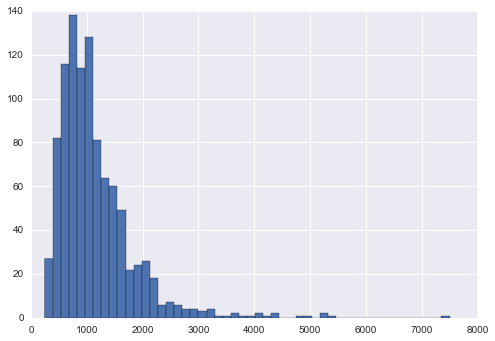

In [31]:
# monkey_now = MonkeyBot(data_now)
# monkey_now.simulate(1000)
# plt.hist(monkey_now.pv_history_list, bins=50)
# now_stats = pd.Series(monkey_now.pv_history_list)
# print(now_stats.describe())

(array([  40.,  127.,  160.,  150.,  149.,  100.,   72.,   61.,   27.,
          33.,   25.,   11.,    8.,    8.,    5.,    3.,    4.,    1.,
           3.,    1.,    1.,    3.,    2.,    0.,    0.,    1.,    1.,
           2.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.]),
 array([  242.47167194,   423.88301747,   605.29436299,   786.70570851,
          968.11705404,  1149.52839956,  1330.93974509,  1512.35109061,
         1693.76243614,  1875.17378166,  2056.58512719,  2237.99647271,
         2419.40781824,  2600.81916376,  2782.23050929,  2963.64185481,
         3145.05320034,  3326.46454586,  3507.87589139,  3689.28723691,
         3870.69858244,  4052.10992796,  4233.52127349,  4414.93261901,
         4596.34396454,  4777.75531006,  4959.16665559,  5140.57800111,
         5321.98934664,  5503.40069216,  5684.81203769,  5866.22338321,
         6047.63472874,  6229.04607426,  6410.45741978,  6591.86876531,
         6773.28011083,  6954.

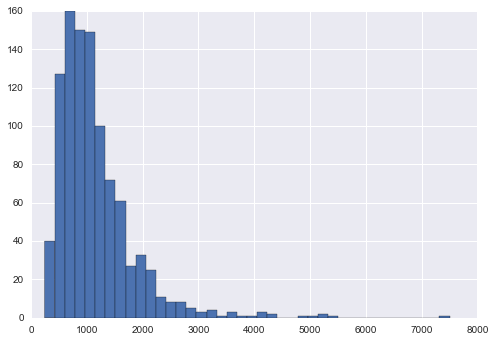

In [33]:
# plt.hist(monkey_now.pv_history_list, bins=40)

In [22]:
monkey_test = MonkeyBot(data_test)
monkey_test.simulate(1000)
plt.hist(monkey_test.pv_history_list, bins=50)

/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Monkey: 1000 times simulation took 62.7864639759 seconds


(array([  1.,   3.,   2.,   8.,  10.,  14.,  24.,  23.,  22.,  40.,  46.,
         66.,  49.,  59.,  32.,  44.,  58.,  67.,  49.,  52.,  40.,  45.,
         34.,  35.,  35.,  22.,  12.,  12.,  15.,  18.,   7.,  13.,   6.,
          8.,   8.,   4.,   1.,   2.,   5.,   1.,   1.,   0.,   3.,   0.,
          1.,   0.,   0.,   1.,   0.,   2.]),
 array([  716.46676013,   761.31482543,   806.16289074,   851.01095604,
          895.85902134,   940.70708665,   985.55515195,  1030.40321726,
         1075.25128256,  1120.09934786,  1164.94741317,  1209.79547847,
         1254.64354377,  1299.49160908,  1344.33967438,  1389.18773969,
         1434.03580499,  1478.88387029,  1523.7319356 ,  1568.5800009 ,
         1613.42806621,  1658.27613151,  1703.12419681,  1747.97226212,
         1792.82032742,  1837.66839273,  1882.51645803,  1927.36452333,
         1972.21258864,  2017.06065394,  2061.90871925,  2106.75678455,
         2151.60484985,  2196.45291516,  2241.30098046,  2286.14904577,
         2

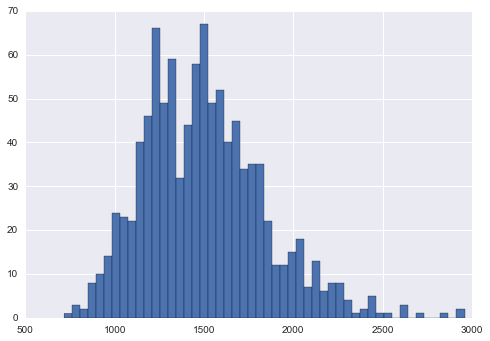

In [24]:
test_stats = pd.Series(monkey_test.pv_history_list)
print(test_stats.describe())

count    1000.000000
mean     1502.137638
std       339.962822
min       716.466760
25%      1251.226833
50%      1478.072074
75%      1700.623165
max      2958.870025
dtype: float64


count    1000.000000
mean     1180.630856
std       240.948175
min       526.111727
25%      1018.410942
50%      1156.472642
75%      1327.664655
max      2005.294185
dtype: float64


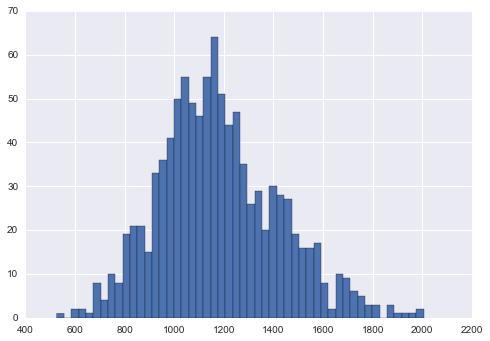

In [42]:
chimp_now = pd.Series([1168.4229143118, 762.32379451429949, 943.48269323919851, 1146.8130282353013, 1465.2372967437971, 1315.1468228640967, 1293.4741708431004, 848.23823434169924, 1071.8900672561997, 1273.1320197258003, 826.18543069479881, 844.39050814410143, 1075.5729841894974, 937.12572382249755, 924.1971733029992, 1424.9806520792979, 820.33428171270054, 1429.3306003245962, 984.9738762493007, 1156.3195657047979, 916.5236855753991, 969.02393375989766, 1461.145810122898, 1253.4050127002977, 1097.6913332519994, 1098.8858187919996, 1247.6237480765981, 973.25278797019575, 1224.9149928339984, 1422.6696200436991, 1037.5058509084975, 1550.9369212622964, 1494.0481769140965, 1076.1820711857983, 685.72120469990045, 862.57849489559965, 1444.2801571412988, 1438.9366555779955, 1673.6000797824015, 1084.6150751865973, 1004.5984680611992, 918.15356280970229, 1041.5549369538976, 992.23902316669785, 1035.4019993514978, 799.39437168829829, 1259.1461953778967, 1246.1732300214992, 1020.7937487474976, 1111.0047897095992, 931.35919614769932, 1202.8122563195, 1376.4120616998953, 1572.5248712744988, 1213.2641686773975, 1328.2074968137979, 1550.8694062909972, 1145.3240347587007, 1186.0475896895975, 1046.0383319800999, 1054.2026762033977, 1177.0739992436984, 1048.6653515198993, 1224.7450040739977, 1251.8787537497001, 1245.7843858983974, 900.89904428310206, 1589.3999548970983, 1161.2184978356977, 1386.546799194397, 860.82629395000117, 1491.9392052496014, 1215.0924628841963, 1544.7060164756997, 1115.6463191013984, 1416.9865349366996, 790.60813317039822, 526.11172718010141, 1025.3487232263969, 1735.8680057634976, 963.1448481965989, 1265.5957152049991, 1034.9852533395999, 1290.1463398492003, 773.61054620999857, 1233.7703093935008, 821.40680201379917, 1252.3437739993972, 1126.9625251753002, 1320.7857020307977, 1542.3719644006967, 1506.1773143945979, 1310.6429979315997, 759.83272095190091, 1412.1902262893984, 1072.3610275060998, 1218.4138386288007, 1019.4980862043963, 1435.1298435999997, 1713.3521210266974, 1174.1798170235979, 1465.3407443961987, 962.62956596389915, 1026.0931612119987, 1398.4911450628992, 1090.4678243796959, 1253.1993334218002, 1032.1521743451981, 750.33173962199976, 843.60827804450003, 1055.6957080044001, 962.63427886839747, 1149.7181907113979, 1170.3239127076988, 1282.5967708077997, 1286.3417562533994, 1385.6609360500961, 1135.860244883899, 1201.4100309506987, 1057.5957966742983, 1133.3624164154994, 1047.5496202777997, 997.1760730414984, 825.82094471229721, 1139.337874991998, 1130.4888229996, 1148.2377320653002, 1579.8543869232994, 1109.1703753123991, 1254.8522623943977, 1191.5381628926964, 1504.9538766350972, 1506.5017139978979, 1158.9725208856003, 1284.6015033975968, 1800.2105730608955, 1388.0384097836989, 1002.396576096897, 941.55291772729845, 1416.7731176698978, 1090.6649825375964, 1171.6103880098988, 1049.0109579993987, 1569.0202040104009, 1003.2393451971975, 993.49862258789926, 883.37502283549975, 1244.1659749667006, 1183.547839387599, 1019.2508413663004, 1214.8388854005971, 1590.4744383303996, 941.0177496604, 1211.4596452345013, 943.5882571943996, 997.80525164429719, 803.59776879599792, 1242.1595200248985, 1177.8905829717985, 1072.007275733801, 1181.5959996047, 1208.8439678355983, 814.048031911198, 1420.3832928371962, 1140.8610703448005, 1499.9614199503978, 1484.743863573899, 1255.5370148462976, 1605.5444100320956, 1430.4444119560967, 1145.9351162861979, 924.49502011729624, 1328.0590837101008, 841.8717715163001, 1177.9807405119996, 1176.9053629613989, 1191.0764915448963, 1559.1981926384005, 1540.553703061398, 893.59496159180003, 1414.1969698161997, 939.94487906939878, 1071.3415403217971, 883.01997990300197, 1499.3586996210993, 1095.7799854478985, 1129.8837249793992, 1510.459332359698, 778.1507388958986, 1060.0098089879966, 1232.6004745308971, 968.11001900380154, 1344.0355418325976, 1149.6858802998984, 1013.9287526805988, 1189.9183026094977, 859.67768261370043, 1247.1009100113974, 1231.8500245029995, 647.14065883289925, 1303.2531439821012, 997.11697108809926, 1417.8384337792966, 1133.2130137191018, 938.61057182779859, 1052.0742238617997, 1096.9270798224993, 1135.3812361760995, 911.17094191609726, 980.04113686019855, 1121.068091643001, 1131.2927399782984, 914.38213531970121, 888.76834765069827, 1298.9503049815987, 1170.8928448873969, 1298.570698007997, 768.74354298119954, 1340.6684182130973, 858.58847856189936, 1183.0874048602, 1867.7691765995996, 1978.2517158971982, 1368.8300036791004, 1428.3529948540984, 1285.5741764179975, 1339.2923803285969, 1053.6930906857972, 992.18949871149971, 1599.7557082386977, 859.93712242679896, 1127.447110672297, 1432.5285759229014, 1050.8147940339975, 1326.7823416826998, 812.72040833389735, 869.80654941090029, 1701.0019653140987, 1264.1620544553014, 1153.9335092863982, 699.52338247169791, 925.55277551280142, 1129.7529074738975, 1162.2318614994979, 1685.4169428356986, 1312.7104259512987, 1087.2069714781981, 1232.4869346098014, 1063.4711064248002, 1369.9770331946975, 1214.199846298199, 1015.4794013587011, 1074.9727717039998, 943.9558971557982, 1119.4442916750993, 1363.1882145661971, 837.12269352029932, 1673.3896526570975, 1215.3304665989992, 1349.6239554060965, 1179.0372807202982, 1158.0752392831971, 996.14991706189983, 1272.3310841666982, 1593.4827696662007, 1441.217663320499, 1392.4306443824989, 1689.030739619498, 882.62247972899991, 1453.236549560095, 827.14006724829756, 1213.3177689418992, 893.90342003169951, 1244.0423978045985, 1212.2030903095979, 1182.6715080202966, 1124.3349010512984, 1201.7988207212982, 1453.2451238387966, 1436.3399729753999, 1161.2871697830012, 1263.3111725997007, 964.70888973379658, 992.03153062439844, 1150.3717309412971, 1616.2079562989977, 1724.3931324774999, 1190.7021927594988, 1293.9480317037994, 812.2629050379993, 1481.9212068134977, 732.50836338269778, 1448.2837098823973, 1442.1054199990988, 1042.2314042734997, 1063.118859249, 1164.3636167459001, 1058.6840140137999, 1156.7836861497003, 698.67851133049908, 1189.5998385646963, 1018.8542150956969, 830.07713539430017, 945.76847602360067, 1139.7325122839991, 1587.1799430044, 1060.5027746628998, 1094.9456079840988, 1039.3730522284993, 1483.0677495539967, 1587.7192769257992, 813.60634615440063, 1412.9698989091983, 860.9552759491969, 1083.965896898598, 931.5075486415974, 1149.9925830920995, 1689.1739000831994, 1087.2699578502966, 697.14704255480024, 1152.0539199982991, 1003.3106909169991, 1327.5331793718983, 1536.6740186864972, 816.62835494659817, 1062.1082518148962, 1017.4641371137982, 1194.8884068496977, 1001.226065034698, 1204.3971240840981, 803.2286842439031, 1044.5984724729992, 941.96216756869603, 1148.6050634472992, 1162.2295521723997, 1894.4293013166978, 1162.1768667063982, 1203.9142559863985, 913.74834360879868, 1281.8974581446996, 1232.1603290772962, 1018.8963122117966, 1139.7636145284005, 1069.1133538166989, 930.08236133709954, 798.71788490020026, 1303.0915458132995, 1124.9031680660983, 1214.8565168871976, 1191.6424848221004, 834.84167798249916, 1000.657864305796, 1053.7232528075981, 889.86357102999762, 1276.4130162482979, 1162.7395494998964, 1210.7750280556984, 1002.4432319557968, 1336.454280116596, 1086.9260467460977, 1088.320292377696, 1603.6712162874003, 856.4093647368004, 1511.1272385455993, 826.35435219489761, 1225.7400548769979, 1005.977328926598, 1148.2063304878984, 1099.1115578636995, 1578.3209339882956, 1582.8895639540972, 1162.666339338298, 1167.9758359383002, 1201.5714676654977, 1038.1629486534976, 1463.6095590418008, 1361.7114504564972, 952.97612180999931, 1384.4581200258006, 826.26132227090091, 831.1219248458998, 1753.3032343459984, 1042.9036650429982, 1042.3334576154002, 1322.8130922449013, 1129.5588164341002, 1446.2692853549952, 1041.9626598155983, 854.66023283639913, 1256.3349425759989, 1001.4612960197986, 1348.1298628943989, 1253.5779407889997, 1114.5160000523988, 910.96227110829886, 1031.7363461420996, 1009.0959655885996, 1139.4582102886989, 1721.9306667788985, 1478.0580347014948, 1182.7051504132969, 754.40603036549965, 1186.8083892782008, 1084.294958541999, 848.99992330649798, 1170.8619899461994, 727.12079151489945, 966.74701929260061, 1025.4410214949994, 1092.5523367014987, 878.72314327390222, 1259.1798664753985, 1084.2031769121998, 1183.474847743598, 1334.7514105078985, 1039.6797419799977, 1486.2516353607975, 1198.8075145278972, 988.67305276999878, 1001.7205673298972, 936.22748287990112, 1405.6528699112962, 1367.1461511026989, 1445.6022917142982, 1133.5322165780976, 1170.504336313197, 1228.6860411767987, 973.73754657229927, 1386.7911810222972, 825.85379588949877, 1259.9247990417987, 929.95605802399939, 733.76675371629915, 1078.0870305132973, 1018.7265434297005, 859.70900544880055, 1171.0210332561981, 1653.4767100435995, 1300.6637300648954, 1311.1407045677977, 1280.5342451710987, 842.8397478395998, 1371.1681856186997, 1092.7894189368953, 867.45634407149998, 1041.512648811999, 1014.4878541117982, 1121.9305776085992, 977.58970531079819, 1705.3360806704982, 1455.7359555242977, 1348.6319694418974, 843.88913783899727, 1466.482831663395, 1189.5167135806985, 1742.651190231998, 1269.7126239107981, 1134.0447140019014, 959.81380350979941, 1265.9850116611985, 1113.4655434909994, 1030.600008962198, 900.4404066674972, 1052.5819239926971, 1306.4106403557005, 1017.4270141426002, 1226.7391041144995, 1406.0573402643997, 958.90242786259967, 1506.6795134774998, 1347.4732523425967, 1066.9943789440999, 1240.5804253187973, 1147.867878053698, 1019.5879769367994, 1215.5625245933979, 1373.7301084799001, 1415.5629105758953, 1029.4970325806976, 1021.2582185036972, 1072.9510189865987, 1177.5573462183993, 1216.6444106503986, 1396.0194434908954, 791.21184983709884, 1099.0974645732967, 1375.0787216311994, 1397.2215942604962, 1162.2955607276999, 1073.2793711132988, 1137.4320475291995, 1328.9249520551962, 911.44475613149859, 1245.1706754952002, 955.84516729219661, 1254.0555811977968, 1088.5162751001974, 1411.6738399137987, 1164.0276910488997, 1088.0216725197977, 1493.1992951986963, 956.40480463299957, 982.52667457499888, 1082.2047381477973, 970.17492292269685, 1369.9361994001974, 1084.688785301498, 1164.733761806202, 1130.0480346746986, 1257.2332794265965, 1225.9597694293991, 1082.2153799985961, 1388.5814236013971, 1529.3166082433982, 1069.924382019198, 749.8148464440992, 1550.676186084499, 1706.8133344697012, 1092.7812976922, 968.12382129429966, 1017.0506397054985, 1056.7355926029948, 1191.2941595285986, 1124.0040748017977, 1375.2997484502005, 1265.6465955625995, 904.31084481239998, 1156.3993420859997, 1117.9211056312972, 879.41714556229931, 862.10385595849993, 1299.2144435267999, 1453.0214547011979, 1282.3948412414982, 1234.2249881227999, 961.10234194499822, 1379.5823490781993, 1239.4732150760001, 1580.321232165898, 1482.0115584441, 1156.0064847090009, 1051.763413218197, 1133.919826485999, 1472.5020378321963, 1103.522764853398, 1541.6402530775949, 815.55749774970081, 1182.7531913356984, 957.84180101579784, 1083.8457972623989, 1761.1012952521, 730.29444542080012, 779.91799722239989, 1269.919903089997, 1428.8955592574978, 1758.7632736393991, 1445.4423269516999, 1485.027821496396, 1053.7492406094996, 952.63807064169748, 1156.7424319843997, 1273.7580465767014, 1092.291590737897, 1419.4292415255968, 873.94082136729799, 1578.7310510203006, 1462.5690048486972, 1294.0947757949014, 1568.3017688001996, 1377.9115477096998, 990.42566006459811, 981.8172199601014, 1061.5220221095969, 1294.7253097538951, 1148.9631465165, 1172.3133413556966, 1020.2834456440986, 818.98405797769783, 917.44463912359856, 1453.6857698250972, 1253.1686836985971, 1307.0431174139987, 1291.6581508790007, 1163.5677819154969, 1047.3317997580991, 1150.4748869262992, 1437.8673204895983, 1409.4441160664994, 1592.3949319164003, 1125.2355335601003, 1019.3353633540983, 831.1173455239981, 1120.3485041290005, 1036.0943570683983, 1414.6696815531009, 1297.7429762806962, 1182.2843659770997, 1131.9779216636985, 1399.2351793021962, 1400.1559391379005, 1006.0897105534996, 1367.4562652077964, 1415.6776872191981, 924.57838617620223, 730.41524086359834, 1658.8833907675969, 886.12438761010003, 989.9817820371992, 1683.1311138298965, 989.17643993229774, 1216.5693879881967, 755.42984015180059, 923.03996513269942, 1413.4096414042972, 1282.513411960899, 1098.9411350941989, 797.5718517952979, 1516.6383056710979, 987.13196401719836, 1249.3820831302983, 1020.946488847, 939.35045245679942, 1135.6657537375995, 1387.4989964452975, 809.89499275839955, 1014.6161413636992, 1434.3692268460004, 865.12205837199929, 1006.6927690168991, 1028.0968915662972, 1749.0540860231986, 868.32644211880097, 973.19089467789968, 1171.7542408052007, 1170.9259755821984, 1424.0000840152977, 1136.657749591498, 1454.9078827706999, 1325.7928061572984, 1179.4948649962002, 1518.8881374485986, 1770.8956226954997, 1120.4836958576971, 1033.7653056109964, 997.15044129249713, 1482.0464724649969, 1250.7838684092997, 1511.3036915507985, 974.10051851739979, 1097.0203052385991, 1180.640591755498, 992.95250308479842, 1305.6638974013977, 886.07407443719899, 1142.5379539642979, 1148.2175018404996, 1024.7915507778987, 956.43444082459894, 928.91598751939887, 1326.1174876598998, 944.76775712239805, 1663.2447577575956, 1197.0608108104996, 1026.4081906969993, 1111.3618490134988, 1375.2458836448955, 1260.0807505778018, 923.48524336170067, 1348.354477063097, 1232.6563986221984, 1308.7250717713969, 1054.2257711808991, 1048.5272830718986, 961.24623642849963, 954.82816430869741, 999.00388588010037, 1003.2558588595007, 1056.0097133188963, 968.32394613359816, 1473.4907097475977, 1090.7660578552982, 1243.2349315037964, 1192.9197288112978, 1126.8604735961972, 1005.4156148550985, 1174.9422519482987, 1111.6516362494981, 968.42385835449954, 1156.3853609018001, 992.58103813309981, 1384.6866803377982, 1573.2626003139992, 1640.1542305524977, 1661.0895916469979, 1264.6213086377977, 1031.4829849565995, 1059.8293219749992, 1179.0226030200977, 1052.6508453182003, 946.12154617470082, 918.74012945399841, 1232.6952941581005, 1074.5627273435978, 1480.5207392744971, 1706.5369589560009, 1288.4447464210959, 1408.9857714112954, 1286.2184712510987, 1321.9557427525949, 1228.026751191398, 894.01062284669911, 1048.9551805646995, 1119.2965843237987, 1097.5170473964968, 1233.7037265439976, 1505.3955763926972, 844.60312716679971, 1428.9545260094981, 1127.2501826112982, 1268.2208011529012, 979.90998209799682, 1253.9129453763981, 1139.418733820899, 1576.5760764873976, 989.28888194930153, 1539.7489802939979, 1133.6228227613019, 1248.7785487346021, 1214.5506123259975, 1393.293471541296, 1153.5053911680975, 1056.7870716222976, 1032.7809447062969, 1174.1803566255985, 889.67098254959842, 1717.5986652126976, 616.47471326929815, 914.23618815440057, 1620.8511024483983, 1041.2312489426004, 1530.4212412858963, 1534.6659897442996, 1187.7999147927981, 1539.7758424880953, 1100.4658153624989, 916.44461139660052, 1020.6355502673005, 1145.9997436264987, 1547.6982115423964, 1206.3427561376973, 1307.5431100013989, 983.32408907599859, 933.80597484610041, 1354.9518121808972, 1242.5353548156015, 1078.8918240221999, 1019.5135590970999, 862.69088208479945, 1045.6676454881981, 976.65342644950044, 1153.0554457218996, 1168.8122958322986, 1069.3166233003974, 1082.9187611333991, 812.96211980679959, 1463.6113905677016, 1563.7178907733983, 930.8612648082003, 1008.8268647306966, 1205.5226324512023, 812.20224705739872, 1389.0777325487988, 1057.0848122473014, 608.85314213699894, 1144.099596853898, 1015.7749414470991, 919.11030678259965, 1453.7599711654984, 1215.0228768354982, 1257.7028481346006, 1049.7617753366974, 1202.0195824212981, 1038.4165541988009, 1114.192110300698, 1084.4996031592998, 1249.0428227225989, 1098.9407316226986, 1184.830480099899, 1107.9015886530979, 1188.2683420930971, 1105.0432973658967, 1302.8477776030013, 1432.0702296939987, 1045.9755504796969, 1677.2691130268981, 1339.1905051936965, 1518.1690750420978, 1576.1519284389976, 1650.4034282608966, 1148.161294319701, 1130.5026071499997, 1249.3704482179007, 1077.5560221012015, 1078.7474522946998, 1204.5582351724993, 1213.5775474087993, 1055.6934115037986, 1326.7372784618969, 1239.6246963809006, 1301.7335349309963, 957.5653960530999, 1384.5950421734972, 1331.2770839832988, 1288.9569970436025, 1614.2173134966977, 1060.1599514890979, 1339.6962274251975, 1777.9401655706993, 1218.8564260023979, 1449.0156457841967, 1673.6305621596955, 1080.9184458117977, 1306.0352059402999, 969.04121290229966, 1541.2388632187001, 1252.7769719002008, 1812.7503910702974, 745.08248160909955, 1174.9148858453002, 954.7128178093991, 1139.4122281143, 1288.1703272517987, 1325.682930457999, 1287.7801370489974, 1023.4505777133002, 1396.1950650703982, 974.59657235630004, 1330.2042342582981, 1356.0920856925991, 1412.9839372593974, 984.40917732949993, 594.53536487539884, 615.18113348789984, 1160.9742301353992, 1973.6876765847994, 814.76559119319973, 1053.6522153442972, 845.27165167880003, 1664.6761342956975, 997.41644612009827, 1487.9211617535984, 1160.2303735006001, 1237.0134772258968, 1269.1587538053011, 1054.3910340556961, 983.72713656369876, 1328.5044916518975, 1234.6986270429991, 1215.1580330324962, 1249.4907138086976, 1523.0106442053993, 855.15540775209911, 1115.864738437499, 1423.9066634655981, 1268.8280985217, 743.33859470640209, 840.95870409069937, 1202.760330513601, 1298.7359376928011, 1191.3960715732997, 1079.586554548699, 1032.7663866309977, 1004.6718953320973, 1191.6179108503979, 1109.1654980659998, 1242.7683703381986, 1129.0058779979991, 1075.0647932363984, 948.51751401289823, 1103.4780142741979, 1156.5459426162988, 2005.2941845569972, 1064.1596802035976, 1234.8239622504989, 1288.6617237439, 1042.0052205685975, 933.34773637899946, 679.87940060869926, 1099.1931086173981, 1512.8938123999958, 1170.1377731114972, 1194.9091249991968, 953.95834652049837, 1226.7307633751989, 1101.5877459912988, 1269.6603477299989, 1278.5127003765999, 1275.804309119198, 1482.2654596783989, 1075.8283136992982, 1126.1033446656011, 984.36799023749995, 1133.3377998777994, 1004.4578183719995, 1545.4779425631998, 1258.0210765946015, 1127.3308867958988, 1361.2824375388986, 1116.8069100863975, 1141.6596296591974, 1000.6311304641971, 1487.4069793574995, 1504.0024653563996, 1344.000928557597, 1458.0668819471994, 1182.6061661319989, 1082.5877536651967, 1461.5912902331975, 1148.2859572591997, 1101.6768771366985, 1329.7783502973998, 1158.0098082073998, 1017.1792420079973, 699.18167806119868, 1027.4470224519994, 1452.5871953363994, 1620.3406975761986, 1096.0598659084994, 1116.3980516154979, 1588.1386531719977, 1306.5532388793974, 1154.9938830552985, 992.6427406985008, 1096.7745252539003, 1375.8244395237991, 1116.1330473141986, 1281.6771388020998, 1022.4024521926992, 1298.2898788918014, 965.91684011949837, 859.86990450120038, 1724.6131851871976, 936.40940524129724, 1413.0601847393971, 683.71034556350185, 1099.0921052684994, 1190.2346064992989, 1352.4763361085004, 1191.2977290318975, 1445.2516895179958, 1870.1903357709973, 1446.1241730430988, 933.18540958489723, 784.67891290609748, 1176.7623408445991, 1334.2982731306979, 1413.4962587933967, 1148.8993290482983, 1423.8445960881961, 1204.9732767881985, 1354.6895224490979, 1695.8542889007983, 1067.6636147020979, 1112.6642260490969, 997.85726977809793, 1860.6101566596969, 1806.3052490168998, 1928.0966513037984, 1235.1217068924998, 1246.9717558789002, 889.69678567029973, 1550.6912817913003, 1502.2857040601025, 743.9273347757013, 1214.721411811797, 1063.362865629399, 1409.5646834704964, 1343.132691407397, 970.60256515579829, 1133.5616268307019, 1170.306806897999, 1233.4477857895986, 1175.3116116483959, 814.050794254999, 1111.2919094258004, 1298.8560967215008, 1133.6028361006997, 1229.8938647733985, 981.38875600109884, 1132.1135256697976, 775.79774599819973, 985.05984902030059, 680.0331707205994, 867.17656965230094, 1049.3441763758017, 1796.9444858906018, 1221.0424235644978, 1284.4256933692004, 1258.613490251397, 1448.1337305513973])
plt.hist(chimp_now, bins=50)
print(chimp_now.describe())

In [ ]:
class ChimpBot(MonkeyBot):
    super(ChimpBot, self).__init__(dfEnv)  # sets self.env = env, state = None, next_waypoint = None, and a default color

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
print(dfTest)
constant = 10
result = 0

def divide(x):
    global constant
    constant = x / constant
    print(constant)

dfTest['Result'] = dfTest['Test'].apply(divide)

print(dfTest['Result'].iloc[-1])

# temp = 10

# for index, row in dfTest.iterrows():
#     temp = dfTest.ix[index, 'Result'] / temp

# print(temp)
    

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
print(dfTest)

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
# print(dfTest)

# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))

# print('===================')

# for i in dfTest.iterrows():
#     print(i)
    
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))

iterDf = data_train.iterrows()
print(iterDf.next()[1][:-2])
# print(next(iterDf)[1])


In [ ]:
lst = [1, 2, 3]
lst_iter = iter(lst)
type(lst_iter)

In [ ]:
test = pd.DataFrame([(1, 2)])
print(test)
test2 = pd.DataFrame([(3, 4)])
test = test.append(test2, ignore_index=True)
print(test)

In [ ]:
print((list(test.columns)))
lst = list(test.columns)
print(lst.append(2))


In [ ]:
pv_history = [2918.3240283131045, 3821.8478066270945, 3939.4570934885824, 2397.8849674453004, 2025.5795376535978, 2734.712748770502, 3245.6111362200845, 3544.8380880789864, 3495.460270078708, 3184.8949370405003, 6967.133003109397, 10012.59117782851, 7814.5676240798075, 10182.684916160872, 11562.349863301706, 8904.540674257893, 16709.828063931185, 36281.94466495626, 14191.692212935082, 18584.026717630393, 41794.01670350159, 31747.51776805102, 65701.13139567738, 56712.0694771982, 63289.881251906685, 88776.9731022494, 80471.52966222573, 82536.0229780134, 84555.9622810239, 97015.41639561074, 150512.60677160101, 180489.08131018287, 64345.44138481978, 279007.0180593079, 174024.17358978683, 366612.5450674156, 172794.7370801902, 324173.2550623718, 349267.77752662875, 451839.7390839469, 517232.15893598396, 842187.2907668137, 781841.3211120815, 1129680.805816016, 813056.8921316891, 823356.7487409075, 724706.5493280089, 1270830.6028853252, 1275772.6422696696, 1371042.71140841, 4075175.121021984, 1382483.419295052, 1880191.2698873666, 3422733.391683606, 3454832.07418811, 3212798.5972811347, 3183686.088243327, 6922849.252691881, 4404295.988477954, 3853448.074873838, 3376880.65254872, 4979964.805485654, 9439463.86454712, 9292182.00509208, 19116529.60117084, 9323278.43855429, 11599596.616283657, 16724033.214657856, 21703894.185725395, 28489711.928347506, 26580023.582673717, 14473143.359343737, 24716815.0651162, 48415943.759251855, 49630394.18505422, 36918536.12942636, 39196328.21014502, 69032754.59900622, 42164349.29962269, 47239472.17614992, 98837062.77712938, 122833338.74517804, 150285851.98756668, 102555291.2494965, 114294006.03076735, 116489679.74444064, 139541894.82558075, 197192841.35831705, 152926351.99625984, 166202836.29359186, 162270629.57355937, 264003622.14947703, 252315086.89926752, 254625474.8341475, 301620560.399532, 232145645.2300491, 283230516.02529263, 307283384.1151039, 244941419.316295, 310500445.6884616, 233829278.00673497, 292903743.5945943, 187815752.03531522, 283907864.50067407, 379574061.4918533, 285174474.99742794, 262491644.27723065, 301813247.5653415, 356299958.35932475, 280968307.2624548, 191342706.17102665, 276670658.32956314, 321414163.36467916, 512743757.48175216, 356619284.48008996, 462982901.51170135, 444366088.413427, 554008711.2761095, 255168414.92648068, 481260960.0325318, 272489984.96641105, 480181096.89866316, 454351118.27192414, 604458604.2893044, 470602201.00892943, 497724195.9779744, 400543851.91315424, 508977674.92890877, 594369470.4320594, 215595465.72873092, 569795375.9885151, 519293707.0953488, 454929321.5509685, 644847300.8429013, 516564394.11269987, 750321296.5737603, 566778634.9459622, 498464223.2809894, 667744823.6810012, 440858219.99787784, 757705667.6484032, 748483716.6266935, 631966835.6436645, 920373286.7577796, 568259844.5168259, 633676909.2523541, 667692181.3173773, 553505611.9593544, 492205101.95657676, 461596485.377743, 750480778.2805732, 558561625.5518509, 439476264.8378738, 908033237.7155777, 689758083.7621083, 489542141.5500597, 636407329.7966211, 627426502.0906539, 706236997.3033471, 658670856.6206152, 872769834.6702908, 641643673.7274272, 889330690.9359896, 621458211.798627, 474965450.8152532, 674449748.8551067, 623291212.3806645, 760043504.9668972, 619067977.3671876, 894648354.4124603, 768450011.5422447, 492553960.2044871, 937569756.8541563, 969169575.058123, 601565034.1652402, 723599740.9183241, 450910847.98140365, 404945432.61731017, 511162962.4648428, 610875472.4085276, 880709399.9231112, 553579492.068077, 722945410.3185575, 861022188.3596317, 1318502183.0893388, 644554134.678687, 1199061001.0894341, 841909856.027756, 996388668.845702, 582916169.3807119, 1046682011.6159866, 641101114.0247974, 867869588.3327757, 808377543.4597101, 705883968.7222407, 927883592.800679, 640952426.722497, 637917031.0810654, 544444710.6504865, 829266218.7163377, 1040078545.7548954, 785879635.4687787, 836708217.8087791, 943714098.59008, 976936770.4982334, 871589634.2213377, 696608731.3605143, 819719635.7129223, 755700053.4385865, 772242586.5077364, 603587828.5125496, 1268400501.9526432, 645335106.7740569, 918208739.304267, 740297301.0450182, 795255511.782174, 858531449.644066, 831214454.2931466, 793569792.5921001, 837850746.6519824, 811464170.9537094, 914173540.2084113, 1019269289.3570485, 711017001.5176904, 856544950.4110609, 1113329186.9891922, 1015200499.7375307, 735476664.0158294, 644395462.0267524, 1057180605.7969981, 686225465.8558282, 862807570.0355955, 898562822.2138318, 769941893.9340129, 804198719.4558095, 573141207.7778177, 1053923946.8869942, 917121825.8331836, 809239003.4638209, 905011874.3045928, 869003812.7110808, 627366805.4840903, 1018527884.9758537, 1076511679.660876, 850198098.5271487, 1182936240.6757889, 1023628187.969584, 840808084.5728991, 769758947.8405265, 1238635198.343184, 716706938.5957055, 807774440.5700026, 1106218801.3089185, 1016620848.485281, 1467915663.1139307, 1217950306.4854274, 1130166804.9259007, 1416504503.4489665, 1275529403.0494359, 1167133703.4583952, 1425923978.5503323, 1632553674.4912775, 1011383320.9111432, 1036616485.8542805, 1096668156.413134, 1322773061.497304, 909449373.91151, 1667388689.6230428, 1177003719.1947114, 1220180667.7730646, 948971872.216284, 1122112376.68016, 1018612856.7282263, 889292705.3972101, 787406396.2858082, 1153138699.9162548, 1058021926.9376445, 1338172322.3285327, 1217704677.4906843, 1019689144.2736335, 1403296606.8296173, 1410038636.0888336, 1649108161.702126, 1265242549.9862552, 1427614128.8019588, 1845347519.8633528, 1333294657.4468334, 1932471319.6480052, 1707065119.8616858, 1659140142.3864582, 1541343007.8256636, 1162728287.6597855, 1660499124.4127264, 1179507291.7972054, 1382394253.064311, 1614603248.9290257, 1512785566.232301, 1243503584.574294, 1424742915.4475558, 1735547006.8484342, 1097510418.2425668, 872737267.0661304, 1488321544.8830042, 1306294189.3348, 1503341749.668855, 1180920542.8298714, 1083274802.373768, 1682730418.6241918, 1313796125.7076156, 933855854.0457194, 1681284561.4736323, 1096183446.9620829, 1555631292.5135355, 1385878396.0320673, 1766175158.4797103, 1170790422.521343, 1489328346.6143136, 1081438125.446831, 1178093665.934205, 1173251948.5373356, 1281124389.1219316, 1460664210.045802, 1566685048.3528466, 984926690.2019516, 1121727654.1708858, 1553165529.535788, 1363437994.3176017, 1072581499.4736441, 1441212683.1752582, 1161077918.2599807, 1741569786.6275465, 1271366482.6541078, 1876461027.4164608, 1607286815.3796604, 1186337873.1348548, 1876634532.6729722, 1121612734.2741919, 1481690714.8915305, 2088703806.8153656, 1244113924.3207421, 1357032632.8336225, 1265610079.8451288, 1410509242.461519, 1397682063.8191595, 1543586442.372682, 1675079995.685694, 1967300181.428839, 1207329457.3116438, 1897253523.2718713, 1086514239.6523316, 1255806656.9027307, 1271356809.0704226, 1162399801.445785, 1595549906.1147068, 1358025729.2109778, 1650563582.8035736, 1614693790.221244, 1601834530.764247, 1922550047.1280155, 1739963528.5446005, 1410940909.4655588, 1379102311.2047884, 1232034011.798452, 1181343625.9473007, 1327413566.2698376, 1254032106.2508128, 1565015012.9003994, 1074330584.9061356, 1276839550.5518034, 1523900036.4796894, 1933158662.7480168, 1190517138.8242276, 1238153522.8214653, 2058474420.8131125, 2626458751.806641, 1518505266.619411, 2101138991.6789596, 1330132830.07144, 1250162971.6541066, 1670561062.77915, 1331754387.2415175, 1181540633.1345315, 1524970200.721418, 1711051047.9765112, 1080770035.4586866, 1679707911.0109408, 1880207963.2085056, 1444017522.6894953, 2203088403.5525618, 1208474909.3591802, 1528216572.466036, 1748575306.7949524, 1677896117.7288191, 2041897414.2611072, 2460372565.684627, 1173259773.1800292, 1462777181.1501253, 2446799763.3822837, 1564452011.4794989, 2214724228.4000974, 2293186110.6201873, 1646321663.8870385, 1586223168.5649304, 1064296167.0629052, 1509038171.5562255, 2191436408.3004785, 1495496400.8521276, 1350463087.4114294, 1341988341.7905777, 1828666875.9674232, 1345726811.419256, 1539934980.1786137, 1266453518.9899683, 1615898183.6346595, 1899716842.6773295, 1940026264.926786, 1228528853.5330021, 1250807963.4390538, 1564226845.7044535, 1233327946.243268, 1731548705.8222215, 1468801241.7076614, 2783896202.9539523, 1161036363.3735344, 1740360219.9077556, 1724806291.001509, 1385943713.5922093, 1497150631.4159858, 2285487345.4883275, 1506216768.4101527, 1777697311.2125022, 1288839515.9518132, 1655044674.7783573, 2373875940.670575, 1335761553.598993, 1537729884.5217905, 1704350298.6493795, 1870128960.6441932, 2044511998.9358199, 1330376990.765517, 1967366347.7519557, 1165571858.3276885, 1411854606.1068645, 1645858058.504203, 1827709189.7099078, 1758750311.6526103, 1933485327.1393168, 1650598821.6547945, 1971046394.214556, 1889333825.1275496, 3056964627.3016825, 1925589592.5009286, 2874903068.5115128, 2109771969.9132185, 1989787401.6806505, 2592801577.4716578, 2079059191.5869818, 2157090847.498663, 2113787612.396843, 2788376656.3295565, 1915082174.5161037, 2223546489.3098574, 2107321789.8477025, 1922212768.4204586, 2401228868.5337577, 3020896893.8906045, 1396225311.0632277, 1968216571.7590592, 1779094695.4222872, 1837860443.5518234, 3528896541.9754515, 2111659721.9743009, 2130878481.8912995, 1749596773.1857233, 1914483513.4919894, 2804354048.367478, 2503429114.287205, 1694801054.7367048, 2216574723.7108793, 1916392857.1183255, 1695087993.7759109, 1975468403.6730828, 1751471919.9862514, 1913871235.5175636, 1153427181.5134637, 2180520331.7573795, 1619381082.290666, 2501066363.3146424, 1823115825.3069222, 1815967333.6818173, 1752920378.656846, 1984867947.6177144, 1342401342.0951984, 1659812156.5981946, 1864753977.3890777, 2405798194.433707, 1259270889.1130347, 1923005967.1950936, 1837809721.779897, 1519578423.055408]
pv_history_series = pd.Series(pv_history)
display(pv_history_series.describe())
pv_history_series.plot(figsize=(12, 8))


In [ ]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from IPython import display

pv_history = [2978.120850945398, 2589.0045877108014, 1615.583069851909, 2938.792709129515, 1874.1253859598987, 3266.9592995998064, 2590.028311998802, 2180.1522853510915, 2729.0403011814033, 2805.8384912876922, 3986.6811560918018, 5158.696484367892, 6416.166299250987, 7811.997053576994, 9055.640933033104, 7513.808492530399, 9466.303472431466, 15723.837826446206, 19681.69584575963, 15175.883356740487, 35672.96336205165, 12023.86485568976, 17504.62499274179, 15510.044167964094, 16433.31849840273, 26085.823099409157, 63129.17712529434, 28498.097888784356, 32276.77053433046, 30335.79717812308, 42509.90317753481, 33730.312561332576, 76962.89357298556, 44585.730224202045, 61471.377693057664, 71652.8819311667, 47373.45845235453, 88954.97538666248, 74976.28303155134, 171535.11395582312, 142127.24231765352, 109003.42292162239, 113406.13025365393, 118641.89167657336, 189142.8854454943, 127879.79738390371, 161465.89237735973, 117185.04497143498, 211742.80899389385, 517641.45200077, 264781.4085039208, 314538.55452818447, 473511.4999452486, 227459.04664602122, 321928.00198926294, 481963.5162552435, 336954.3014345333, 482518.49538509327, 221036.7462543341, 628099.7222338399, 503336.34476929985, 862128.3938778908, 1575967.1056552287, 583825.5454383368, 904985.4433364444, 598427.2939362051, 1400257.1940334076, 948684.7040817677, 1978869.0421268647, 627745.8449642435, 1924105.7871902178, 1052779.1535642562, 1841079.653434981, 1132620.9213592303, 2612484.969159391, 2741598.6456313934, 2202985.65651574, 2591762.852829812, 1832853.9229296288, 4499606.618423602, 2752378.2515647244, 2584328.1635664585, 4148589.5910951938, 3847501.3483654214, 2758051.3068197276, 6187939.139934411, 3608886.8863580883, 10167858.92055245, 4099296.070107225, 4996321.029684342, 9356203.628081186, 13021671.857980302, 15078148.03922328, 17111373.980669457, 7972945.420184139, 16423793.495305458, 15899415.257149791, 15933383.991044967, 12313151.497428814, 23267226.75547318, 17155759.329630073, 15068425.510415806, 11930430.59309687, 33323577.22017842, 26722450.871071573, 40026351.87017422, 24221352.081904717, 43656381.690116584, 26726653.746059448, 41395344.87452415, 64830792.171848305, 44868324.80709413, 37574474.598145224, 49679142.816460125, 54804848.98292741, 64610098.05144303, 53262459.2429713, 76041695.75104065, 107333019.2084112, 91074658.62367702, 109495849.8613294, 142402890.3854095, 101915096.81714143, 152540438.4265868, 101230024.56750734, 207568404.89669046, 124302292.91759303, 107676401.25036584, 141818216.1145358, 187640824.6050381, 277357290.92158437, 149209335.01165977, 133258900.54502635, 361758054.51596284, 272774248.865059, 356312173.34903246, 229296543.51158503, 328431973.4869832, 244615850.98647067, 407094761.5816893, 368037324.38865477, 492248624.7510704, 604738292.8870761, 400721528.32547295, 676682347.0457654, 647534696.9381701, 487382438.253443, 405560794.8142263, 504904966.4200774, 777888376.2057035, 442465053.7305104, 549339795.8870571, 622069887.3695307, 527307870.8452844, 394326037.3595601, 565456026.5273459, 477546904.07641745, 275874455.62681156, 557606177.9833201, 616663707.3594108, 508073939.49938464, 680071430.8536443, 419533109.9028891, 717105269.2237291, 484122857.22192264, 589761455.8141974, 571701935.6211358, 561918815.2103403, 1013906335.9277126, 626921783.83985, 526617875.9971462, 806438479.9011261, 708823650.8576399, 642673845.2843423, 964706822.2152961, 996968478.6444465, 983286085.4534551, 742365883.476478, 1107287823.0744505, 947643975.6495212, 883125348.8186548, 891916988.241553, 1310437897.3162322, 797291643.9223626, 808033272.3426188, 948203805.4943372, 1196347307.8210094, 1068728603.8124596, 621659443.5135628, 666512759.2658839, 980384118.3777306, 887236692.9129449, 777234301.410423, 1142361844.4653563, 911985283.0242794, 805825913.6530608, 943661103.7628247, 1097765448.9033403, 641076919.7845787, 1224275650.4304574, 1227275313.878174, 777591672.4027503, 1159777337.5308945, 1283789872.987535, 995727863.2503663, 1011981529.5736747, 1013321190.7505966, 1421531039.5785944, 1154452958.2008371, 1126250226.6430793, 1162905001.3234491, 1423981622.317355, 1467492099.6788259, 1341294921.4647422, 1123328481.4779344, 1573256461.3905752, 1278284012.1281114, 1213246993.7669077, 1097166411.9148026, 1217094014.4623027, 1376466711.1924458, 1993840602.429219, 1553372495.3035228, 1144143547.8935704, 1198549165.4682105, 1452592535.214989, 1168643625.6171772, 1242293764.88163, 1092745111.456727, 1810991328.4553266, 928935821.3428543, 1222228752.340389, 1515477363.4032226, 1057477710.7520121, 1317941369.3773336, 1422601736.4237194, 1253319817.7134953, 1883620596.5528843, 1045828852.4425887, 1490810834.8287897, 2196057915.423447, 1004855529.1837326, 961601821.1775062, 1974505816.2338843, 1191527293.279349, 1356685429.2384965, 1518915260.2144125, 1225869159.6926053, 1813748571.0536964, 1368161308.2836576, 1380446872.135529, 1035519462.9631246, 1405578280.342818, 1422185516.0588765, 1059560226.0355206, 1585650194.2324154, 1158546865.4203727, 1287514019.3913572, 1164125151.2572765, 1676607669.360198, 847648875.0067916, 1234187133.9935067, 1665086715.5617347, 1285904786.229615, 1326789357.5781033, 1445239807.2929282, 1422278649.7614048, 1190632218.8997738, 1175537886.496062, 1373772496.6846004, 1504982484.0514464, 1186031341.846214, 1592353145.236303, 1772727819.89769, 1497502147.097672, 1105244699.0603132, 2405718249.1326766, 1528431832.561737, 1683213990.8264434, 1722183938.9000814, 1530950269.2334893, 1657816655.788481, 1098649271.53364, 1951056343.8160074, 1506657740.4855192, 1408574544.2322083, 1539267452.247047, 1467090663.2323282, 1885350911.93728, 1616972066.12055, 1534342347.3232102, 1760414075.6878362, 1257273481.4161432, 1368167078.0832083, 1385698449.2953353, 1359507598.3722973, 1805390458.9010196, 2099452127.7352738, 1258586265.3662941, 2271646779.8417935, 2268632644.6097236, 1564751001.3756275, 1958970703.217059, 1950676036.4262147, 1630386700.622301, 2169418146.7205725, 1537737181.9560199, 1653009504.0523725, 1919444628.2731328, 2256392565.5919, 1767309163.9495804, 1695208155.6791515, 1748133491.9392974, 2119497487.527298, 1997217064.6717677, 2014521137.4189465, 2021124758.1298563, 1830864640.8215857, 2237374016.12404, 1645947120.1888971, 2158744298.8485208, 2124212849.7207065, 2738701640.6849847, 2010777879.0110922, 1922210849.820766, 1712939179.973091, 1951686224.5181963, 2645727965.580346, 1853420724.430088, 1794032955.0574393, 1891652137.0931964, 1393545549.931697, 2556397030.9868436, 1692849885.1050925, 2020824278.392588, 2138027615.755584, 1787881211.5237107, 2162945145.271782, 1812841575.8255892, 1797668031.1528752, 2573253452.0792665, 2471586701.0492387, 2198155332.7395225, 1839287709.769806, 1389760446.0425873, 2664676572.4843, 1584429344.061923, 2226721628.405509, 2056873511.326467, 2160756203.3234367, 1757277620.4969165, 1934344822.4383016, 2026941919.4773066, 2315485045.038964, 2310326064.584887, 2600875341.790943, 2173516427.470107, 2499371591.095701, 2583210646.332255, 2424638816.1951733, 2223165846.218805, 2179187831.7280483, 2344234864.966371, 1914352157.105978, 3260209590.883808, 1889343618.2078848, 2196739781.57973, 2703162267.3822494, 2473808148.257627, 2491673261.084885, 2143555596.0433767, 2292265802.1217217, 2720012055.5714197, 1991398128.8816104, 3397284978.069829, 2696125591.8633447, 2405923098.8629856, 2169181922.037109, 2436578014.1337147, 2104131662.812015, 1709271869.9074483, 2244325859.2653465, 2214063905.54494, 2487961914.1944532, 2226666932.93135, 2388283546.3589025, 2205024263.7521114, 2268773087.8900566, 1750556333.5707746, 2505065021.8541117, 3152627296.645988, 2231516784.158172, 2300164616.588891, 2445910873.0754824, 2676586575.9795713, 2531526319.253654, 1926187607.8748815, 2167483046.439447, 1720058725.1277382, 2476898705.149464, 2335187282.6933265, 2370110287.5302887, 2121628599.8088036, 2320595197.043307, 2051476250.5123112, 3210573169.5103683, 2917676502.8944316, 2375159057.1973505, 2532353958.5101113, 2288520849.491104, 2387495390.9068637, 2481258856.822402, 1882978258.8268032, 2492043549.962855, 2612498948.8732524, 1734290827.3488805, 1915700377.678468, 2714913052.989506, 2736420153.6604958, 2517927921.9092255, 2292185702.5621657, 2753013997.3807645, 2440664863.1991043, 3251780034.558778, 2393841220.29687, 2667433449.274303, 2586811826.6109443, 2367973200.786166, 2485335041.636698, 2377513616.0796456, 2027392616.1000514, 1910218746.5387568, 1907346948.7301598, 2355459963.8895636, 1770090117.5585566, 2824030614.398804, 1971420335.519686, 3158526640.735654, 3146088031.11699, 1839895143.5258703, 2875107304.9973445, 2644987267.1390414, 3348422469.7227273, 2835937868.5335736, 2621408768.490837, 2496528425.0854425, 3021874577.4747224, 2546375522.7019587, 2436477489.9620786, 3213677255.3284283, 2858324747.410809, 2694072965.818768, 2240804323.7468424, 2690144634.772189, 3111570464.395768, 2497290584.0086083, 2995567940.160317, 2549778063.709477, 3208050957.8746347, 3348568167.763783, 2796734002.4010797, 2743617952.0658693, 3651037848.5241895, 2177664666.265986, 3215605135.918843, 2699050305.0867915, 3443656631.996666, 3191508819.181716, 1705686522.684711, 2166924018.3473406, 2933143343.3565145, 2689662580.299579, 2827885323.057951, 2582472845.556307, 2989302968.612532, 3183921762.298791, 2825559376.1152763, 2299448961.9646707, 2542607858.3522544, 2626916693.973569, 2807016050.731473, 3103781274.637845, 2923793053.5488777, 3231783109.868883, 2486052145.1800876, 2806353170.9614897, 2907969978.535845, 2742625739.2310004, 2390927797.994823, 3919968105.239589, 2540231761.5188446, 2804928806.798789, 2549405798.9422755, 2565354047.977463, 3109851715.59284, 2999414729.801244, 3504564780.504738, 2895934591.1021056, 2812670813.5152555, 2146362102.3542957, 2997828430.448571, 3505072661.283978, 1743966035.7862787, 2944216768.7591705, 2204042018.753384, 1746703333.7160676, 2997567124.777705, 2651660598.2523127, 3248763425.4700303, 2478444786.6660547, 3082641951.432283, 2520275454.943651, 2626119563.29228, 2769454876.048935, 3457644800.220056, 2950109853.8500743, 2884339681.267514, 3142138806.3531394, 3745902579.9829674, 3540043228.355594, 2557909792.3671546, 2566766125.6317887, 3448641521.3115954, 2953411904.3179765, 2796014656.6557302, 2977247849.748264, 2489511285.0901046, 3172398361.9096403, 2619144771.842283, 2544902736.1399345, 2881114642.349265, 2225430137.7258496, 2690605857.231068, 2401578516.745371, 2706207841.4725714, 2613835891.262635, 2771836802.47369, 2881555079.2031264, 2752732690.6493483, 2887452892.1796174, 2727143789.8948736, 3526364850.654537, 2490311074.2722235, 3308847278.4106393, 2685667110.3187647, 2843078206.148986, 3291092837.047131, 2286947723.6285367, 2847639267.1804748, 3218316063.745887, 2978872583.1020975, 3499661991.517417, 2624045461.9333553, 2831999648.2063017, 3390465565.2749434, 3467756653.766943, 2455260671.5020137, 2250265411.3269787, 3084280580.92821, 3416133285.999003, 3294003884.7605476, 2611699073.4456096, 3423160419.749321, 2974221700.7833896, 3634968050.0924716, 3684493745.6618953, 2737426871.128788, 2576775365.492732, 3244019740.424362, 2719226219.810915, 2911708897.3817344, 2903392472.6150994, 3687124990.9722643, 3211554540.513891, 1885689851.7998855, 2555475241.7136216, 3063131912.1232176, 3931520750.524622, 2660500181.7319894, 3150436357.0093174, 3656977539.27272, 2426794958.878705, 3850382620.0852785, 3097530413.569601, 2967575409.756403, 1877819434.0440574, 4018796263.818749, 3112583449.455238, 3756918524.8521843, 2846273143.4183526, 3219361740.7122884, 4294761475.003534, 3821500201.269205, 3683805296.87457, 2865662512.1689854, 3086824824.358123, 3333604529.2340255, 3306195357.821707, 2839504081.619291, 2968737864.0635576, 3829227865.886339, 3271494892.1929564, 3928466602.313402, 3117269023.1421394, 3592939889.1358275, 3568980797.76903, 3307083259.8107085, 3892604186.597069, 3222850105.2636285, 3636028148.194275, 3648014264.0756884, 4488883299.413533, 3551305517.6179223, 3392348068.0924816, 3068828183.756311, 4434097562.589391, 3215445181.167498, 3580242159.8588753, 3781983213.494984, 4415445273.831031, 4243692254.054504, 5392344471.678211, 3473455686.5631647, 3750912631.730071, 4263614175.703706, 3669913059.1002116, 4208425211.2377734, 4645997583.760537, 4081250100.5702405, 3735084582.853569, 4061069061.1320624, 3393570283.0407295, 3728965941.785772, 3694543841.4766483, 3152579240.117116, 3267149422.3630595, 4252395446.0477247, 3278176570.067089, 3722132853.241219, 3218693976.877368, 3186505897.236522, 3187402999.380916, 3461978823.9086976, 3018209335.7126245, 5404214869.785477, 4255713276.208592, 3955889639.3071613, 4402813335.67353, 5221667797.050235, 3945914758.730762, 3876783141.4818044, 4360401042.230115, 4211463006.198284, 4240989804.0973687, 4259339811.7333317, 4344091328.729248, 3583664216.533975, 4170136466.2349334, 3580816591.704323, 3290356168.2713614, 3688669424.5493174, 3819100271.528908, 3519392792.4391074, 3483126362.937593, 3693823477.2138777, 4172798431.62298, 3737384784.387383, 3633132077.306669, 4111605789.9404697, 3787024000.4847507, 3645472811.0627465, 3153984273.4553156, 3878078449.4293823, 3348068692.738881, 3581265306.186384, 4348174973.5055, 2931886036.164913, 3565171263.7341566, 4343020027.649394, 3999390804.7176905, 2829777025.369303, 4475978319.494112, 2953745549.2530675, 3552268566.916641, 3989731907.8143945, 3142364857.939245, 4568233050.68205, 3270171759.3741107, 3709685369.2006288, 4858058371.9105835, 3769406372.2305527, 3323710910.3742986, 4701360578.147363, 2801409245.2576137, 3848172952.921685, 3984643933.3314843, 3681280079.044978, 3883738180.0396047, 5610956173.983186, 4849980693.4877615, 2678325055.032199, 4348972589.667859, 5440764467.081485, 4534465468.911154, 3645338638.928844, 4826491378.285075, 5039174637.178706, 4192752682.756379, 4258434840.289082, 3609179295.8885, 4595105004.309958, 3522961252.4896674, 3967226727.1205482, 4004468476.4807873, 3282023603.521833, 4621087916.483483, 5019555755.666473, 4543584170.039752, 3831039454.972409, 6277174723.762917, 4044852121.225185, 4671830123.139556, 4632021926.513421, 5202691613.771147, 5360506680.161506, 4829557014.327285, 6126154589.570018, 3675271512.853434, 4865639473.464035, 4249838296.2239056, 3757683072.7770176, 4702830731.994105, 4636841355.195638, 4624324564.2517395, 4821134853.394335, 3941102853.0081816, 4624471262.810704, 3769104576.465129, 4529491906.848101, 3974370117.272045, 4598715743.988594, 3510222823.666344, 4286531685.153093, 4825771167.317956, 3944443877.237455, 4496311428.151561, 3253796654.125182, 3182280781.0552573, 4446779963.991002, 3963475289.9304256, 4857184649.664549, 4553815399.508839, 4899301074.895724, 3963601586.773608, 3266630767.420274, 4129074399.6294694, 4698030907.895283, 4008451559.4391437, 4551695573.712662, 3936782165.194642, 4560979278.466278, 4007217980.913457, 3233435279.082134, 3806468661.722678, 3914981588.2728376, 4206965768.4110126, 5341212799.478565, 4975453837.468916, 4463174603.727359, 3888897035.7227736, 4165377086.2297497, 4057793706.167751, 4528977258.221403, 4966332873.251946, 3994262155.705217, 4345079736.001518, 3664696721.3351626, 4437750917.773028, 3866572981.0416594, 4693785876.250622, 3401530282.279015, 4748530958.793107, 4213689865.176485, 4529470021.14573, 4191439536.3054557, 3644674741.4518747, 5354849565.682683, 4685354317.965271, 3841619230.0387936, 3948729225.465469, 3820514062.8759413, 2993659512.6930914, 4464311256.048768, 4738874290.24087, 3743155618.342264, 3861138097.532618, 4586133492.383653, 4092080263.3497763, 3451182663.5743966, 4262553196.7945065, 2886443322.696686, 4569817746.024245, 4474950279.955271, 3870941660.6400466, 4468288585.257625, 5204270434.514756, 4795688092.660345, 4161469405.5554533, 3691059011.3013287, 4769486528.450025, 3578103943.610624, 4384882260.744747, 4821953448.221815, 5451208858.81273, 4198724236.125627, 4750231498.236522, 4788364902.846731, 4653144486.675838, 3909378363.1261954, 2994462853.0711017, 4838512211.333481, 3488583905.765259, 3488544465.950672, 4401248835.821996, 5625108697.835692, 3851337390.4435177, 4789860059.131647, 4728901601.386598, 3612974470.3191185, 4932974799.212209, 4527490899.076108, 4228767188.4591312, 4490979983.068408, 4825754546.509579, 4973270022.962669, 3335821993.9628215, 5247920085.593027, 3795959309.5751534, 4878242976.827975, 3815552963.040333, 3139000072.2752934, 2955304326.952823, 4156149311.030339, 3211317229.178181, 4401176040.621584, 3322959115.8697968, 4344057053.884082, 5059607967.517364, 4182550737.282435, 4391972184.707659, 4268364811.9522376, 4146791748.931035, 3926735414.076909, 3189234687.922862, 3805537106.128095, 3607213710.844698, 5034262072.049445, 4567618911.796153, 4039788094.5455494, 3375913795.422961, 3167391886.5424805, 5455101349.8450365, 3708606208.6975884, 3827696168.9313755, 3644364489.7124295, 4522485139.019033, 3611348126.904172, 3256537395.3162837, 4184459078.4907055, 4062294163.1472626, 5304040221.641692, 4352266147.455472, 4043917290.9111166, 4559145022.191999, 3647865373.2979918, 3544362047.176596, 3925466694.3534694, 5245892321.261464, 4622872144.157832, 4394215177.080629, 5559931307.429348, 5303534955.047536, 4135809233.5158277, 4270279923.1430683, 3184044484.21704, 4917690862.902254, 4759460326.145176, 4121027688.7151737, 4572303060.659785, 5042503584.021214, 4310983333.385231, 3965865958.421309, 3190946874.0710387, 4284149642.480365, 2813465171.2626734, 3818566694.345023, 4356467600.197597, 4858696878.670046, 5041649665.529842, 3119554287.9083323, 5681171267.070121, 4209087131.593753, 3930923109.2971716, 5693643513.969475, 2946195707.2456727, 3742399318.2961245, 4202630029.524335, 3514324114.7808075, 3966281941.7423186, 3676426696.2319593, 3724605428.00057, 3257897527.048752, 3363140711.4083886, 4438983520.425256, 3706609394.275191, 3561594515.1017985, 3163177119.105308, 3154508915.143987, 3202820821.5874486, 3945508817.211557, 4449263167.101336, 4103601922.813507, 3572500128.996427, 3575411328.478615, 4297095827.98273, 2928128370.39131, 4456432689.427256, 4584159060.739043, 4367260028.163743, 3457586671.3849716, 2692999062.1722717, 3369015300.999768, 2967957910.307259, 3655206709.553364, 3927401388.515455, 3283745683.361357, 3190316338.183868, 3176505415.4035187, 3909238491.567847, 5065977199.747943, 4134899917.431922, 4160533297.3772473, 4172113855.402673, 4482709374.173774, 4786887476.43463, 4403609184.233527, 3856527113.761172, 4339194364.4159975, 4019957761.0086417, 4089443573.814887, 3428101224.649761, 3035252700.8572617, 3916435967.36864, 3904688379.6714416, 3551975135.216711, 3915627029.354979, 3720867854.385352, 5591857014.428451, 3022858677.824608, 3551402828.849783, 4765556954.541735, 3702113453.1985087, 4105205425.211377, 4395349946.56058, 4621646401.43883, 4951271136.006248, 5478914106.448715, 5005968295.717456, 3958025883.9337444, 4802762940.739556, 4856727620.3895, 4912852564.229645, 5314874379.648275, 4594887425.010701, 2929750766.6309276, 5216680453.6918955, 5267134333.653272, 3437130818.561371, 4268823143.6518483, 5287770572.046233, 3152580208.128569, 3936119910.000472, 4790879965.606991, 5006512555.107543, 5254541089.703056, 3477208815.379331, 5810070322.191122, 4208984139.7205353, 5014679104.143975, 3471370767.041907, 4540789759.82783, 3421867100.154834, 4327702819.968909, 3781088337.48292, 4446116542.115131, 5678114397.167361, 3972269582.473476, 4279967672.1160846, 4520226292.096328, 4096774862.502534, 5305926352.140005, 3895157657.2941236, 4767191127.420533, 4009027292.967994, 5107977355.407505, 4994860952.659453, 5244921513.089709, 3805113876.7620683, 4779519152.0059, 4166407010.4557533, 4502689729.486248, 5042033254.404832, 4649824637.180134, 4112584438.7576923, 5063875735.193974, 4815061405.179813, 3906921380.7429595, 3584196038.588783, 4813773491.848255, 4714677097.652673, 5183499318.802092, 4569017190.918041, 5841026627.317144, 4339543042.716976, 4421578698.799025, 4995296141.004146, 5155337766.7511635, 4012765346.344824, 4654239430.556782, 4453627332.681699, 4185044187.403197, 4837055309.144289, 4255222096.095739, 4692400646.279624, 4259405705.479679, 3759967590.3550134, 4689037409.161361, 3798213895.551657, 4352285298.049656, 3913281957.992429, 5271530328.828979, 4711730235.069855, 4251595874.1002793, 4892228649.709645, 4059257194.6181, 5355638213.987234, 4856805350.157566, 6271516032.258267, 5503404978.03885, 4263604583.3559084, 4785501597.536143, 5012176393.784781, 4629853725.014708, 5046597252.827233, 4831309613.510031, 4104414727.6397476, 5129008316.08064, 4519652790.585259, 3777846671.5765443, 4545778448.347309, 4566481037.866236, 3389259213.2934194, 4429180582.19954, 4053157549.9987607, 5607712621.011791, 4853785918.422916, 6091704243.785622, 5913220640.433841, 5269784628.693671, 5027179590.708196, 4444129985.669822, 5531211137.05504, 4497868815.315679, 4648942925.371847, 6456061027.085388, 5568749586.668235, 5447331477.294271, 4556158470.164462, 5132995595.8444605, 6565417511.049211, 5493363339.548152, 5276249821.495252, 4576638744.384886, 4623086049.754472, 5336604914.342566, 7068829997.961773, 6635001303.4937315, 3754164325.8195953, 4946492515.416328, 4662139820.270382, 4438836914.220997, 5106030607.444625, 4529991921.285549, 4880199936.137243, 5383386189.433084, 4717298907.273433, 5304479237.706828, 4434506317.555099, 5984227701.951848, 5256257259.777445, 4935640706.705134, 3860149233.4980345, 5146514487.079988, 5090657296.035887, 4088722913.102557, 4952304708.250503, 4703381154.683219, 5054979614.848686, 6230918801.685756, 4816800333.885979, 5149462621.213597, 5151246195.62596, 5541973563.1722975, 4981768649.874586, 4424236290.423309, 4646940874.000705, 5346210240.018794, 5941059955.774494, 3715052355.1271324, 4770904941.491357, 5073605194.743588, 5118724996.917642, 3980902761.8582993, 5638569978.698173, 5520451975.366649, 5773923134.727, 5899692539.62699, 6271348365.552209, 4000391719.2289033, 6995351357.913878, 5636351919.290437, 5698997483.384353, 5234799392.789916, 5505718869.952011, 4737868594.163292, 5851962469.503413, 5939473782.578606, 6154125989.509119, 4731129998.1003, 5416979059.901681, 6260252201.1610775, 5491683428.998347, 6424534399.645286, 4781947793.066051, 5991239920.308199, 4638229620.832047, 5063784402.203632, 6485152773.92597, 4855130637.444185, 5437594542.300641, 4698235026.967216, 5225996224.863493, 5044228956.067681, 5697557455.73256, 6363971637.918787, 6838535658.250025, 5971722847.49247, 5031863497.483861, 6121322975.653366, 5297732158.720308, 5125908867.631648, 6112046357.819481, 5991158925.46145, 4794226407.589727, 6272656238.381531, 5481244631.771726, 4901744312.388865, 5886955013.905897, 5775016963.682368, 5304238346.488888, 5614941750.742557, 4755337539.209127, 4797343123.517156, 5594748970.927233, 5048547131.250714, 5340494247.513401, 5872231001.838196, 4554158860.588767, 4251409869.020558, 4646948649.898762, 5382088848.1599455, 4112157070.0372534, 5114043888.70862, 5775644331.021138, 4071438338.367538, 4357832127.326139, 5776779596.257707, 5245986076.115014, 5578701431.456072, 4560314356.336902, 5010156469.125296, 4943954623.608842, 5226725966.584629, 4304495623.420197, 5149491623.689545, 5605568901.263576, 5815421484.496565, 4889137841.013671, 4929789740.286099, 4908221739.595333, 5483088066.060532, 4529330420.428177, 4870203534.786223, 5176165593.237924, 6127494543.095228, 5784093590.240864, 6008435356.606349, 5517163343.075609, 5785919912.172384, 6655765918.395166, 6270624697.059372, 4857759512.828586, 5830835752.562743, 4227848931.474031, 4504055039.362755, 5780568813.30017, 6265558917.786325, 4854547266.8523035, 4723263630.999952, 6086551537.935186, 5119519594.829012, 4783550719.389897, 6269392178.108248, 4567250330.985633, 6361247003.8084, 5908235429.543221, 5993442136.138124, 6200846285.040126, 5608098589.659056, 5738787140.287367, 5489381389.296483, 5903925051.939829, 6193454611.872191, 5254237684.310519, 6458821401.018809, 5846266777.4684305, 5375587121.617742, 5928727426.58322, 6191260822.555169, 6985204522.800613, 4848600286.736592, 6954978857.626468, 5378063464.748851, 6100684122.311222, 7304840712.9716835, 5785530828.86037, 6024414183.939033, 5902553466.621737, 6306719252.468118, 6725734859.828701, 6014238770.315957, 5763129569.657284, 4657355278.924826, 5635605003.367201, 6004866205.599048, 5597944075.415329, 4470985108.709027, 5879038346.510925, 6557208141.51197, 6468980276.4270525, 4019225548.8175364, 6239667365.037454, 4765806307.415069, 4516868850.718495, 3629736158.866343, 4851680419.265785, 4529328616.104163, 4436469455.179034, 5728638044.965646, 4221861465.46178, 5175047444.616462, 6236086631.611533, 4225991472.725142, 5200362511.809192, 4399387414.916267, 3682317103.1543627, 4607635812.857947, 4985312857.442879, 5328318272.972935, 3933071075.889692, 4539966224.788227, 3807496624.9749136, 3979346295.5212765, 5295703732.25713, 4776616467.929036, 4837441009.008525, 4946431368.751413, 4287794369.810943, 4221464796.131581, 4107669529.6749697, 5315674124.365317, 4307657588.684062, 5213573322.874611, 5094718810.492423, 5489922389.50687, 4739765261.847479, 3687538127.586774, 4318750591.7225685, 3702515456.8515882, 5065267098.860061, 4168124348.0209756, 5005625873.427923, 5108695302.020524, 4678783121.570138, 4652646035.479162, 5580199455.730877, 6150957696.731605, 3918772274.222126, 4837162574.177523, 3592163882.786382, 5597442216.378669, 4658033715.62986, 4671616591.378138, 5865872311.99951, 5448534922.005226, 4586225515.892967, 5342795294.7675905, 3766545647.824065, 4822985700.083187, 6006353515.468029, 6330444908.502125, 5474197842.204964, 4548920511.267931, 5302953049.286571, 5081514243.844031, 5905434554.500101, 4772076818.6178665, 4250753715.0255647, 5036247066.15882, 4449304135.65172, 6582662124.888037, 5968070319.136916, 5715927880.508628, 5757556553.373499, 6220756042.776266, 6062717545.6696205, 5683533650.964379, 7020837865.898408, 4619753314.412162, 6219189389.801055, 5246405844.752702, 6807461271.740275, 4500869522.556148, 5568637120.034159, 5845978022.286629, 5531522527.696609, 4821782938.638238, 4445012327.953742, 5240135823.903145, 4377570941.529703, 5250740100.01435, 6696390287.8252945, 6039365892.041288, 5315001506.912526, 4996845093.694642, 5164913504.8279705, 5252180407.743755, 5081958129.901109, 5969360709.628946, 5230909062.99539, 5387215719.679139, 5222260442.103863, 5346255013.568714, 6850240536.369199, 5491300093.719612, 6336284835.538471, 6402798465.898457, 6727042739.348035, 4152047642.9267135, 5364985756.711974, 6071439548.327686, 4653935825.915524, 5989454066.84516, 5232509686.641235, 4892349937.975202, 5660711136.670136, 6343991982.35797, 6190725857.32065, 5683347718.75414, 6300521459.959094, 6556260269.167996, 4978980622.280069, 5486198563.38302, 5332721082.6291895, 4466723055.481632, 6138189082.068893, 6630081930.955665, 6240671736.753999, 7963347479.3800125, 6114772057.729016, 6687060927.570764, 5961492427.800178, 7649826247.801712, 6728402742.607311, 6050163007.671572, 6330732347.252808, 7110201673.021613, 7225987191.676884, 5355940096.81673, 6238197171.235967, 7092320683.371905, 6028362961.4855585, 5379270409.513316, 6978212013.740349, 5354860153.272189, 6657510958.87933, 6130250374.005579, 6369656087.226979, 6230587546.815902, 5614760647.187543, 4909035356.217964, 6396293215.33086, 5868731126.139081, 5668834316.019108, 5227822135.260884, 4297646124.256771, 7192692603.956979, 6419762701.258801, 5931462612.641613, 7121419002.23921, 7961187693.281156, 5633371160.868322, 5568447337.900745, 5916102132.013405, 6384333567.969382, 5848006162.886752, 6521281661.138317, 6009884290.282424, 6581732124.817535, 6832942168.359822, 6178719642.486019, 5816612140.605244, 6107063442.860468, 6066209545.476541, 5015932072.1237, 6638373112.809871, 5185603882.623078, 5613800882.432697, 5453115495.720401, 5274618772.054327, 4646610946.389765, 5302577655.510117, 5749626497.419732, 5212325801.578665, 5737900313.494867, 5339663158.947102, 5052438312.722904, 5692254680.608046, 4891691663.956618, 5456660772.970837, 4776432513.338486, 6183936394.836782, 6789033375.023642, 5511984499.931469, 6077074409.81692, 5692826139.466222, 4946789378.791047, 5697415300.672081, 5500677794.20613, 5648294155.443063, 6978563640.953713, 5767814933.575579, 5929829408.285106, 5470375180.935477, 5170632039.812254, 5707990411.375954, 5726796885.453136, 5757305926.847592, 5704446978.256086, 5716844849.270729, 5580667149.974635, 4743550039.131296, 6638115780.778849, 5432322097.398802, 5626124876.490483, 6334193117.639764, 5037803183.382868, 5381913072.422237, 5976463979.106977, 5573403097.759089, 5869297764.243526, 5848628517.574791, 6004776109.328808, 5053172116.226661, 5283099219.6560335, 5842950562.330414, 6461604237.839547, 5330994493.905834, 5840994972.27874, 5974312367.280455, 5972867192.026882, 6684448219.203686, 6706815462.898704, 6301787549.851594, 6753285478.482748, 7511103242.111818, 5217156938.8053, 6681076462.172868, 5616457421.310908, 7360597041.404743]
pv_history_series = pd.Series(pv_history)
pv_history_log = np.log(pv_history_series)
print(pv_history_series.describe())
pv_history_series.plot(figsize=(16, 8))
plt.show()
pv_history_log.plot(figsize=(16, 8))
plt.show()


In [ ]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from IPython import display
chimp3000 = [2884.9821560014125, 4820.5397859355135, 3329.9795470897011, 3044.7884534487025, 2787.3670540991898, 2544.232890275598, 3897.2073434599101, 2468.9855436727003, 4749.0896389355694, 4137.2456739029076, 8287.7061792604818, 7130.8241369325842, 5038.1182604848973, 6366.4010047013035, 8461.1783992265191, 3627.9841041128052, 8248.0272638159713, 13633.878232822306, 7330.734690486207, 16072.856874099074, 10617.720619485748, 22001.645899451712, 14637.355448173874, 16143.575465869368, 13960.462777124627, 12425.086277533548, 22802.565890078553, 28137.284492035818, 20150.092498270231, 26673.652276364774, 26685.874031051499, 30508.626670036203, 42029.674487183067, 20285.379392575756, 41713.331234300887, 89773.201440692137, 105800.07058586934, 66374.477555887177, 56074.200494362514, 104919.32767722593, 94292.515341358492, 66360.137186344276, 62005.514260426877, 136389.54784061163, 155046.04191304027, 92259.407287948328, 134655.28765133503, 83591.360699006051, 171522.94818740699, 460951.82281368581, 124618.62329554385, 140006.10756615279, 200261.05310423955, 176530.7709768537, 240931.50255936655, 412139.96527294273, 185508.85228577873, 224766.31168745007, 276413.63741456257, 777392.63917129894, 384120.18856511964, 718373.5111009432, 470907.87992895668, 498767.70433406701, 407099.21707029419, 478551.22779017972, 438831.9810021533, 1160859.3791541462, 832576.35262320843, 1100899.1663580008, 1081106.0544509657, 1371117.247556441, 1646040.4025569297, 1342425.3637849914, 1438335.3558358566, 1021661.6177563572, 2543065.8653255682, 2858921.9008670016, 1509719.2250549993, 2308835.3167521525, 3067666.1724135177, 4503946.4828031827, 3594586.4539431189, 1871229.2518726776, 3708277.9730201368, 5481884.1394934552, 4140410.3949799156, 9468776.3631481659, 4583456.107303516, 4385053.2756802188, 8037466.2168347705, 6543298.5258124322, 4101110.5149397701, 6288576.2477986077, 7823765.6210939595, 12699014.21802629, 8343470.6715220856, 4941444.692440547, 7913167.8168474939, 12112085.778890187, 13020099.316870546, 12682274.918039214, 7132129.6715911869, 13056277.604135297, 16584851.947659608, 12699181.877381934, 13328166.400120493, 14852883.76158426, 26952174.366777997, 17761561.195038848, 22720296.949995358, 38908258.565888487, 20293578.605551433, 45520585.821802899, 18190436.197922044, 30954633.465042137, 25962264.372830492, 62770112.384235412, 50397667.890836805, 57116470.960399009, 65689058.54411047, 75532518.680293635, 108444097.47676675, 32202063.359808967, 67139799.832887754, 87005799.098463506, 79594822.660523161, 115630429.07361998, 74028391.085852712, 90371958.794534832, 113370921.03787118, 122578212.65672381, 165407405.1535131, 138983905.8800118, 205340339.1265811, 184467937.59618866, 130180083.58401884, 190150355.17635137, 321476459.57112145, 118088586.33722402, 227021550.8955659, 214265521.08571464, 314455116.85922837, 268362464.84912738, 359441636.10686207, 335490585.11504227, 291178065.53184158, 227248500.19960013, 327717438.23762786, 387391387.88469315, 329485968.65967906, 454550634.84759188, 391538196.32534593, 396556353.25586194, 334150307.23322082, 367304227.99402648, 350175718.26475608, 360530425.04698175, 220464091.04532146, 305631151.75319624, 316388851.28103113, 355483206.1907149, 281543967.2135067, 336627712.27433997, 425629106.0758639, 215825584.2925944, 469943516.36171538, 270729813.85440755, 237458891.73814934, 358706608.38859767, 301979598.78008181, 354969335.96862382, 456154438.7874614, 340951420.79936284, 392508309.54153401, 361265725.38287413, 526507924.82591748, 359300491.47414678, 351575389.89515841, 410915869.53014737, 382225340.1031428, 441397666.5636735, 555993906.8094312, 412717316.13803422, 531092557.45256948, 548043016.29974794, 691566306.27918661, 404957626.99905014, 485989675.23602939, 453900710.31845629, 630252349.80174661, 548789727.42341173, 437470260.87389499, 564566623.92076313, 552342510.90558469, 730621282.03372252, 576819104.52802002, 536120335.04021847, 542845985.28038013, 643849360.80888176, 748892162.84170055, 741213545.52237558, 614057220.41513932, 752041112.76076055, 820031111.48000848, 441454358.97985882, 631918707.94423282, 645934749.80409014, 409493155.90015805, 556740496.69492006, 870030356.28401744, 457799314.124327, 419324632.8934043, 572080207.48415625, 762765874.6441313, 555675110.90605402, 634352053.33294582, 461749820.10557997, 873889078.40598321, 647540998.09544015, 591924282.97475266, 817188710.05319619, 712970269.28103054, 967244928.13776457, 755481361.52175701, 703608685.7449038, 527850338.08408201, 617963221.82858396, 695302302.38093412, 426076442.19358259, 800577882.1566695, 530286421.53592056, 633672494.52217507, 656538024.61752808, 687844202.48565614, 771131441.40681744, 737462377.11989176, 583466042.81993651, 605598964.29535794, 548149832.62660289, 601613972.7310046, 619127298.54044569, 608450054.09542537, 448493848.30649614, 435802574.45696384, 695895387.62950027, 469187163.01746726, 568820619.76303256, 539535600.75764751, 628578450.99560177, 523477968.50476646, 650092935.42355061, 644439117.38947785, 705205272.62409651, 494728087.70605648, 533730993.76834691, 667002583.77819395, 590882587.50446069, 443015649.33887595, 626867420.85153317, 685933869.36080408, 777449380.11034918, 663694536.77289224, 427161731.2447927, 615983982.8791703, 565723348.07967007, 693930333.81022596, 531817380.00934649, 750830355.42785978, 598442240.64176214, 483680176.6980862, 713592986.59135091, 515704389.81853634, 795098293.87792826, 614608103.88722718, 502923113.54978275, 522694453.14370662, 505781454.35531795, 564836441.59811449, 441266966.11099946, 424740341.06647342, 457916585.22516292, 441350689.02237284, 634109757.99954617, 733672146.61241698, 549641394.50362074, 555116143.86277902, 667480020.5497613, 421274567.66537279, 691481179.58907318, 440668204.98808759, 887966241.74080062, 450354325.79710472, 561590374.47887206, 547419552.10966969, 664331761.82875812, 533080885.94547707, 580794139.29124177, 765691714.82756484, 599324866.50601792, 626068458.56082022, 719373636.62239861, 735829354.67360854, 469450787.51805383, 789602580.56073189, 626829984.98913646, 486860490.64685374, 558718941.41872799, 639237968.43062592, 605576970.22853982, 658154604.11441898, 509695671.14632761, 517258787.93017274, 672776588.26977623, 712040381.89781415, 755815188.29294682, 688805401.55926287, 522247373.67695469, 641505292.91536272, 803768224.82362103, 732633796.83180618, 785955652.9451499, 835588105.58553243, 655308667.96143186, 636862225.48088396, 795008225.46920788, 755313533.94036949, 1068342641.9976375, 654114711.0109508, 941703888.82621467, 567301258.533252, 528424141.92944938, 957132194.72579801, 418307951.15611142, 678974553.74961936, 784130364.19366217, 693667641.18265343, 678136637.42339444, 717307258.9191165, 478419154.05489731, 655102991.26818299, 925293143.74971795, 668304913.99231398, 713685688.59431434, 698174286.88897049, 502704252.63201195, 611617810.26253223, 813902041.48237157, 606507168.44433475, 601410457.89631617, 535828606.56784344, 727608119.00620925, 565458150.42675173, 866727867.13730788, 707951925.03184664, 413919772.77886128, 853219434.0734328, 690029783.27822995, 560806887.65368128, 729650151.73886514, 574978482.25552654, 698817232.134161, 713788727.15498126, 636127127.93209291, 695856683.62421119, 824117587.46377182, 631734550.84330726, 748606822.95605063, 748571008.55892825, 541199967.55721796, 610090734.92013633, 611580514.36497033, 572726000.14980662, 694412769.30565155, 899170064.50281727, 450348185.19954199, 646464836.63345277, 612695477.86160445, 698152557.02344012, 706926127.66312373, 726153787.30769551, 614268623.872105, 921296927.90567696, 680921111.67561424, 737554362.23805881, 639268424.90981257, 635559178.80026758, 953253451.1045866, 906787419.21809995, 573932592.04888248, 1081316119.8874135, 872340413.88020396, 687744391.36286128, 687278840.60780656, 526516687.84864539, 612852770.33192694, 747086824.81922698, 648767892.09463525, 787826910.8884263, 853737257.91716981, 828680759.76137114, 1044552385.7470132, 1079739227.7492723, 502242754.94003016, 927567400.9578383, 866505898.43544376, 682504188.07300389, 612659790.44350851, 747005526.76923621, 923777798.43166351, 584314126.14137971, 628272182.92518497, 760312912.57187724, 918676137.37123144, 577033002.05259275, 793764572.90083194, 795096928.87642264, 743820979.04572761, 644511407.60183418, 652028353.76108277, 631901046.97359836, 838292272.90275979, 571727423.85927033, 658242385.36130106, 751402143.50710344, 785894264.90951884, 773346796.79020441, 762024830.41440308, 576179633.94780517, 549549320.31223154, 771997070.6645174, 547444874.72099304, 689645250.24764645, 837400339.21999419, 666986850.66407764, 673727015.40108192, 740451652.14411247, 703856663.83191657, 771277644.73005462, 1035581342.411826, 670613828.59688938, 664416147.96317697, 876918463.52277899, 815094498.51529539, 655042710.99920452, 692224849.59728849, 623886628.61514211, 702373744.19383121, 459843611.45546043, 727472058.25700152, 887151615.60364366, 618386814.94833302, 719297250.41888463, 631822405.00822926, 906753748.37636578, 593266611.66277695, 963375245.3993305, 687687333.37140715, 839387350.50339365, 804002816.64761281, 973977196.30342305, 828539021.28663337, 786103061.11927974, 950195519.98400593, 581579607.39511395, 887115240.90460825, 718342728.41406846, 766720968.73109984, 532316692.02253437, 1004237570.0287176, 666733326.0614357, 704543010.33846092, 685369989.40060246, 638412171.85048079, 772213463.24118936, 746113041.60730708, 902756239.71429217, 826175539.81990767, 745967516.39060533, 712085103.42184579, 929160189.54893398, 914206283.24265873, 562130343.11381793, 930613710.43479514, 554493098.66876554, 595407651.19825077, 806844404.66866207, 689341062.92215979, 688172627.8896395, 838339352.82751775, 853305132.54119134, 607671302.82657719, 584523226.63071692, 1343466963.487186, 753202352.64079487, 540559785.44316947, 852772423.33939087, 947805414.74968863, 764777257.61966145, 608384985.61105216, 629578131.67556179, 812953620.39613855, 752688514.2945106, 731163057.40840876, 785958599.3759259, 858614757.48643231, 922885623.29492545, 727929033.08278167, 933339858.29115093, 499971508.06428951, 1051481168.2011288, 928285778.98437774, 790115871.88878024, 994355606.17693937, 1179477321.3941054, 930359004.55623376, 882528381.34542, 1462950831.4710445, 1011396876.4223251, 613965031.58311319, 851326023.74053049, 692141175.68745399, 1120256486.6601963, 973748678.05497348, 593448234.4236834, 1036583661.3989217, 840781647.02577734, 887215102.03446269, 702487793.87802923, 945911328.24773407, 724608809.00979078, 1058062105.8139701, 784151486.25996828, 778687599.12060547, 871845274.0915941, 857850239.51712012, 807053814.74807775, 960392383.94930255, 1043604360.3893102, 668545027.00659478, 930393139.26584852, 1076774326.204356, 740891094.91226304, 966555161.24865294, 901775374.02789736, 860731829.67888331, 768625629.95561182, 756455670.78859484, 1145936823.5291646, 638053812.85587597, 966061536.1494571, 999626914.12181282, 727043608.77220213, 624030466.82452655, 753658929.08371127, 617181697.16037786, 691937798.04589283, 810618912.50030899, 1116173555.7190468, 733419704.49577129, 702992261.45300603, 700383656.69956541, 651056177.9036516, 927235077.60361969, 712303038.67367709, 935326039.76990938, 609371104.06718683, 928332060.10615849, 835331732.14706326, 816134830.53975403, 1001193410.7788372, 674250654.3532517, 899987258.3166064, 1045736189.0091339, 1021406550.1793717, 1099644025.114089, 1191324442.3320217, 950032944.34596717, 996341261.16264451, 717608757.3121264, 701815721.11694992, 1021954443.6503646, 958867259.10218394, 746599806.86283016, 961598748.8290602, 694737040.448475, 1070250295.590917, 640946876.84174418, 1657893516.8421977, 619926238.10612869, 674764419.091609, 786891695.51872206, 839765183.95706427, 908217864.72875035, 819945904.98958611, 1070826551.2767611, 931476515.58738232, 826707561.26930165, 1088399795.622997, 951643917.28807747, 902312318.60456228, 1280185288.1905684, 890716039.6372335, 784121186.14228261, 1050961419.8553373, 832310918.46782041, 1184010773.3587534, 1155033142.36885, 1004948439.6258607, 754010368.09964931, 1209260063.9778936, 1009707674.7916194, 717361697.79781795, 789164736.88053918, 831381938.58917499, 731299491.55268919, 818373939.6350373, 826630932.33850694, 821198371.46835947, 1083000535.8458405, 990337550.75301564, 1402784354.4365504, 1182165838.4446363, 1122335882.1235485, 1361341358.4958231, 1008925824.6025063, 1091564634.8735352, 966779414.13053238, 775449178.18099892, 1004959402.6612927, 982614471.71149123, 1050193419.6223066, 701023600.849231, 1160888346.024472, 767429762.29173994, 1174171179.3608067, 1123926595.6852508, 1036727448.6420138, 919098446.7623688, 843140235.59855211, 901397392.30736113, 728381670.20859253, 761274665.5025661, 944990193.76483154, 771082808.03010237, 1002364051.8394343, 902026092.3151108, 907473251.65446126, 921549135.33839929, 984014512.63865256, 1099747292.6360514, 969405156.39285278, 944696519.70785332, 821665971.71900964, 890331907.32665837, 676644284.19753635, 974199408.1383754, 837024270.01673579, 590149809.30782485, 902623886.02984941, 890606060.02435207, 679409060.02018642, 1004392929.4208882, 772037921.1545037, 746606178.38500571, 665840778.34510398, 659850936.04347396, 850748415.63198411, 852718202.58090448, 842923252.88001978, 872493660.3194524, 1093888149.2796774, 979476238.48497641, 850325274.22431052, 1028870031.2600523, 833599492.51115608, 1059905150.7648152, 775823739.16735947, 726864334.77548301, 1117487846.0462513, 800129976.13082671, 933189480.41865873, 830503917.46235836, 899821858.52390277, 947364790.08238864, 821612801.31319141, 1031482567.2587278, 1331996866.6835623, 763619661.61107266, 992848366.231264, 953765164.68403733, 1160578851.1534348, 1319146766.42066, 747589642.8522296, 972904067.81607664, 726677093.89258528, 1058780353.1921475, 918997284.54898751, 1031318852.772764, 662015758.84002674, 929467665.03903306, 928008513.3032726, 740094352.28036201, 1089307579.7255459, 875522227.02827239, 980202632.12605071, 868861065.66843557, 978808115.54165494, 886142134.13034165, 1099793846.6921773, 1264635811.0168006, 1072924048.055033, 914982373.65804946, 875355148.27397168, 953291156.9929713, 878640750.8230505, 914267100.45297301, 1372211367.3797503, 890456535.48342049, 928428838.20174432, 1272465949.2805979, 1158511787.8380876, 740398945.77287447, 877145188.10659897, 1272771731.551755, 975093465.8935765, 930641410.25503027, 1138667378.6839318, 903381091.83621681, 905323601.69611168, 930288090.88691258, 1021438923.804014, 1156494491.8316097, 620567665.6844126, 1007789909.0527141, 704730776.39689505, 1136318312.2254176, 1057166206.7924193, 629885843.89291477, 706391794.19127965, 712707131.7146256, 1108100243.4856968, 812800157.8922627, 1661699589.4293883, 693615332.79036045, 1068891266.0623792, 807875541.41188455, 655950388.77706969, 961623815.09474254, 819052017.80749547, 896315708.51248956, 1006002121.4647241, 637944176.93652892, 998724605.39730895, 969211463.76010966, 697245607.03818166, 677684826.02448511, 646371956.867751, 853355658.47120869, 1381149678.6329587, 868710859.95879126, 1013541391.7692665, 1131007096.887429, 919285807.97369969, 1073887269.983438, 956796902.23681295, 1555843640.3375442, 714148647.34393466, 882511654.47770643, 825025413.76395249, 1318978701.3800871, 1119539582.1659048, 1069391693.6525937, 1046002130.6031096, 972070883.25725949, 1173993073.9991288, 1132703994.2660606, 986330521.81527627, 1108665598.9979584, 1112355057.6798198, 1050256741.1726608, 1040815538.1918448, 972916659.31198621, 1940531906.5841591, 1157031923.0344274, 1073619920.040023, 1448802584.9047434, 1188322292.8300481, 1186265826.4517257, 863701475.30681646, 1081890200.3380885, 1106369456.0753736, 1184400636.4617095, 1048619967.7656806, 1292089532.9279432, 1084314270.224113, 808544510.69567895, 988982347.66345537, 789223699.56627369, 499675616.14401692, 947963799.29545295, 826253231.35616505, 917823747.42260301, 969375609.53471053, 967273850.74635661, 1026912565.8639413, 1124936601.0261767, 678496328.16135192, 687214679.64709496, 1024545390.9263768, 1012261557.1435694, 1176193032.5725193, 1253670087.3734896, 759110375.69304764, 1158249174.0871611, 944203478.97503853, 1024800243.6676111, 1385303942.6205544, 794654917.10140848, 874340324.82488775, 1231607655.1665199, 1017348433.6891373, 997013925.6621151, 1051060834.6157608, 1031507527.5064965, 1246954256.7729187, 1249754083.3873384, 802875824.65147078, 1122806398.4111078, 827206378.00053346, 770912731.18814492, 1005858539.8364134, 1196507646.6277206, 895659659.27890289, 908548984.01565802, 1319305391.6153738, 938645690.90091515, 1042067740.3888738, 1190408228.1807141, 1130201611.8205826, 965506558.73310208, 632427473.07122469, 1184786108.6919727, 979355526.90802693, 982108087.59544063, 1013729392.896908, 943992387.26889455, 1044225301.0732596, 999469372.79999447, 1268261497.9766729, 1093021650.8080754, 1374301805.9021719, 951078432.8363446, 934017170.89676642, 1361968892.2696135, 1038791463.8293042, 1007657597.7222247, 945433836.13919961, 1014296531.3746361, 854218041.05521059, 1172439404.4554014, 818855574.24008524, 1138679592.0277727, 1094318021.2055411, 844060438.09824002, 1172427811.7381611, 917505784.33524513, 813732647.56247878, 1235473023.3181901, 806211862.03618073, 765351420.58133399, 1156980591.9795163, 762551424.11413097, 751328244.39781582, 913467205.01552272, 1071505828.3050711, 809989137.15300155, 1022656882.1597741, 1223180712.3956742, 1050368537.3484963, 1190226622.4273303, 1379334759.5635984, 955165798.88502717, 895741809.75495601, 994484056.00263882, 1098334051.5760705, 747169371.51028013, 1269487025.6899257, 769517514.01364505, 1251243150.3985629, 1121130737.2502415, 1498131105.9102376, 1237344898.1459746, 963116003.00434208, 1321551706.5338523, 1076908382.6673341, 1463006911.457623, 925756082.21107411, 1145263508.0114615, 1015640681.5147575, 1419435283.9218893, 1040583697.7045211, 1058669997.2088107, 824031195.57238185, 960989973.86059117, 863721682.9662379, 782829785.24993336, 1316576205.8090715, 774572007.10470593, 1229368805.4522734, 834184811.72724915, 949720614.55320859, 1108448503.4885581, 764372253.09576571, 816778666.92795753, 909940006.41853106, 736568383.85785961, 983115372.07489848, 986826641.00618184, 743632011.00624382, 900319054.63205433, 906186845.35460711, 814762103.3266449, 848193295.61635387, 979138184.52754891, 977288659.794819, 1126663920.8242209, 907543161.86707616, 826052653.73584211, 978179334.88368177, 1157993235.0363197, 936639926.85082781, 1027956442.4648871, 768776705.60737789, 768526666.29918993, 783775953.44173467, 783783994.33333945, 988302815.46105158, 915708264.20294142, 651984284.8182689, 1102346616.415307, 775455768.63932157, 1012154232.7968365, 963624978.30555439, 912137842.04318023, 1056922442.5211252, 736360937.68594837, 963033472.89278436, 1239528382.7108305, 1170971169.9897046, 723502390.22251713, 925901916.21480596, 970959055.39126766, 1011847894.2707744, 801969147.56681025, 966636099.84405768, 779235400.14627862, 1052441205.5380191, 982880378.42787898, 977842005.97144902, 1020072338.6802933, 803735502.43168414, 789183729.96873653, 955888485.4584682, 969905229.60981119, 863986339.666278, 986925240.94434965, 833432963.80539465, 943811676.70782232, 944693233.9065665, 879562666.92040265, 979719222.53640568, 812965093.94045329, 1267539730.9021678, 790185756.99490166, 911345862.71641386, 932013446.65137196, 991955930.31391263, 741100592.285254, 1228910728.9553416, 995393457.4089334, 1225273942.8623095, 976190251.42225432, 730588766.85672605, 946755569.77629972, 885230132.07097852, 1479622955.9933498, 1079559955.4617486, 786357169.54214036, 1074663034.4696729, 1081500721.1630144, 1267409741.7691045, 791286902.95588422, 1138061782.215404, 784206818.09230018, 832903895.12043107, 987369493.02984035, 949590148.29668093, 883453268.67064464, 1052440149.3901139, 1147621916.4377825, 940412966.20380497, 753969760.98017788, 806284611.68990827, 983907727.31237364, 725852694.38877654, 1120505835.0269909, 992863761.97972977, 750297923.88236022, 985733211.60270071, 1000068290.8063524, 1133963798.327481, 1151174034.1379986, 1155877814.0904067, 1133702001.4538448, 1080986922.414156, 1266785103.8642709, 1019593159.1314306, 1152447282.5453997, 1104474940.3111095, 1113901961.8410115, 914955182.12237811, 1211219994.8482561, 1052665139.2669564, 1215938144.1715267, 977782080.57828748, 1148520419.6268246, 1329507429.6002855, 1036216263.8897612, 1208199596.0506008, 703472112.61323118, 1230681822.128516, 1273772534.4099658, 1454245906.509665, 842091063.20008278, 1539540338.6138394, 1166825247.2860098, 1275354271.9797032, 1037242216.6714764, 1327675817.8092067, 1307327980.7995973, 1181789348.7754462, 1060863146.9513193, 945186512.83607018, 901596365.2847271, 978660095.54189181, 906401119.0146817, 1047583200.1095392, 1258976669.2350972, 1001607514.1419914, 1234230444.7431765, 887163159.64183736, 1195800303.3474295, 947940987.19011378, 1175734335.0486002, 857870661.87588847, 1069719598.5737464, 843597726.77840996, 684137164.32379985, 834691687.14367115, 898818997.07393718, 801427730.60050976, 1062772886.3358864, 1101921095.1725638, 1041680501.3813558, 1104986570.3090281, 1382509649.5627921, 955415508.69256091, 987986991.95384467, 1736653672.9285371, 979660214.03322375, 1119676044.6118884, 1056677412.4178439, 1040152469.9023689, 1031055791.0989048, 835102884.95561194, 1178770237.3647854, 1099965201.0242481, 885932297.52473438, 847518943.07192302, 844727108.53052771, 739213841.70752788, 1111656271.8733292, 1132225243.6388528, 1102339722.0722096, 1162483842.570915, 1010772502.4480808, 916876381.97778881, 861318733.70770824, 1053165595.1703992, 919125193.4947933, 919086622.18421638, 1065138227.5313357, 1023618140.9853376, 1055703080.6865422, 754068848.54822814, 1224645470.1147346, 985243024.58917272, 843843929.0178175, 1102682690.8144288, 786724833.69184732, 873224755.00652313, 1208115438.5230572, 897120508.0392729, 918616889.95463574, 634330090.6282115, 881276057.44168019, 1013923124.1533487, 1083472864.0119865, 887844928.35802972, 862110930.27960503, 995360612.76815689, 1230977647.5581343, 917407605.13786221, 1182086190.8769772, 985557407.24138188, 899716442.18183208, 892176380.35254848, 1351701156.2541721, 832935148.76920617, 948910278.84550941, 1283127659.643538, 924509449.14375353, 920940798.51847136, 1040334069.9630097, 1177208521.4200404, 1044920964.6596949, 1267087323.4358938, 898891778.44637501, 1117240872.1181328, 1004155219.3906734, 1176805953.5279784, 1159566043.4291523, 1008383660.048725, 1359960901.381747, 1339459268.6451614, 1064764264.6534796, 1486665929.6361983, 1100784896.0684304, 986090794.82552505, 888652761.67016137, 1128747096.7249889, 1003006409.7668247, 831540143.52510023, 1370862216.1463234, 1064156463.8614947, 1141976088.059757, 1168011046.4739184, 1303662775.5244415, 1059825723.5079077, 1103188863.6747539, 1328176740.4729648, 695110265.60785711, 1151141146.4376452, 1003785646.917701, 909102056.9645592, 825438333.09972155, 919218257.82764304, 762936951.95846272, 1301131969.9403021, 1056975856.4792905, 1087686860.9376178, 665236850.01111984, 1444600127.8439503, 973009218.32600355, 1030686072.3166567, 787985462.35445023, 1166428840.5385542, 1002459866.4012686, 1370286357.1702509, 932718039.88143945, 1046479935.3839816, 752889139.48089218, 1240406923.5847082, 1027400420.0149812, 1248598560.1967497, 1101341192.4134469, 606003855.05573833, 966478019.92942643, 760916411.70463753, 788624203.51922548, 971535307.17667532, 885930856.59487069, 1157563385.9363439, 1078726519.8868508, 1074867812.8299711, 1167427420.9794061, 1177690600.0096402, 1258385660.1319683, 1468394364.8528674, 1156334900.4962702, 1390098710.9741426, 1667034379.1811244, 943280227.24344146, 968762512.87834132, 1079520823.8172197, 1251665101.4248278, 1163916593.6560452, 1007341663.7769713, 969121988.91189849, 1129143554.6646805, 1181084657.9026191, 1110382330.4077492, 1008435357.8265461, 1106074296.3253922, 1251665945.0678959, 1252029493.1227505, 908093515.85173202, 903737243.34991157, 1112029846.0514581, 1064187423.085983, 1162827772.6050909, 1963783032.3994131, 1475009691.3690886, 1124099450.3889544, 1379150433.7243292, 1099314526.108366, 1584027050.9018302, 1295560973.5352015, 1221554724.7591369, 1524721916.8952205, 1443117495.6250365, 1348262668.0668154, 1302631469.7847755, 1451786575.2328029, 1220354525.8661878, 1305849919.2521708, 1395991205.808609, 1340614534.1862652, 1324850490.2286596, 1076581156.4183674, 1394949000.4348917, 1297014422.8438079, 1253223869.3371582, 1260179720.1256325, 1122142402.4323187, 1266385682.0678961, 983790055.27358043, 1129956376.8023875, 799769176.08827615, 1053513977.1616225, 899588570.07665086, 1075833602.3290198, 1309385233.0680606, 897574345.52896595, 1261169664.3221641, 923358707.23932767, 881284713.47942603, 1023573038.2199074, 1247596336.0606554, 1216904837.1285279, 972267719.37971628, 1813022554.6694934, 1031551749.7782778, 1016911701.576916, 1344403615.0562203, 1132875482.6087897, 1245435241.8878098, 945927891.38849747, 877418717.98557401, 1159354484.9993625, 1372541014.8573518, 1038366865.7925327, 1210681651.0281529, 1291758670.6449234, 978123209.15649116, 1295337124.4539227, 1630428348.9749758, 945439465.63063431, 1069407187.2799389, 1020604915.8943433, 1255302050.6546533, 898623258.99379861, 1281163720.4356527, 1569201833.6287212, 1052709504.6834949, 1500431367.2247543, 1264585032.4140718, 1497411552.5044296, 1179460231.173346, 1456850186.2539573, 1179729832.5258801, 1108539266.7588866, 1305597130.5651052, 1371006781.1355474, 1443446181.6976945, 1569472518.2659967, 1298473287.6784356, 1047999248.9654415, 1044366992.641458, 1468916427.9231737, 790004596.8248688, 950564942.98191261, 1248681554.8489313, 1327442974.8786013, 944339497.57795703, 1363825912.8784757, 1304029350.2704, 1011394797.2610222, 1228117282.1495481, 1727470107.7238674, 1032856523.6398065, 1006089650.6541741, 1452910192.059586, 1435613357.4439163, 1081962616.5681603, 1229540564.1867025, 974267038.56399274, 1134026933.9217937, 1051103984.2348468, 850994151.63491118, 1286880767.047622, 1457959755.0450733, 1173243570.5070546, 1139524932.2319043, 1222395753.6464045, 1611348768.1629751, 1254092395.3090863, 981925914.52468824, 1134175691.5866096, 1200424366.1837301, 865179029.31016886, 1450402341.3920836, 1027601537.2383254, 1259608076.2536063, 1386867695.0334013, 1410878769.8526499, 1310066091.6945612, 1313311855.3149271, 1259499529.6447542, 998890430.10489869, 1527079868.156178, 1514447434.0359485, 1478456162.5344238, 1485490157.2386429, 1464812886.3901868, 1140952183.9043164, 1157197635.8748221, 1249231614.4645398, 797721203.03407609, 1389005655.2186141, 1117284516.8835609, 1151961637.3468199, 1160232554.2975898, 984637035.8944459, 1074301840.0397325, 1025660059.7347608, 1293931687.5781746, 1341555780.5095036, 1191328177.6488576, 1198351667.5825143, 938127834.80453849, 976722337.19605422, 1333344870.6720693, 1002400872.1208496, 924143562.60991979, 1092283441.2641609, 1041625189.4748507, 806175459.20535111, 1115755903.1109517, 1003548268.986076, 1244580654.4650295, 991907574.30587447, 1096474646.6146984, 948521514.89944553, 943453187.70909965, 902309659.84542942, 960137842.1159569, 1237597396.356514, 1132163780.106602, 970246151.75679171, 1314452460.2466328, 1156779451.6517107, 814324528.70600092, 952219784.56483603, 1153446930.2755833, 872459280.05556309, 1115880125.5224214, 1006852952.4943365, 1052688558.15971, 1285356534.0002401, 1029261517.8674959, 1135884034.8197794, 1109664639.0701149, 1012584411.8120948, 1258157618.8159702, 807620357.25570047, 1093635015.2980599, 977555165.05466342, 1430913706.8237879, 1243114685.1430063, 1483867842.1640477, 998514907.65419531, 1206371567.9291615, 1101972434.648417, 1028882843.7526096, 1124171116.4422307, 952124753.44878089, 1033939267.5749247, 990753217.84256577, 1329210026.0945535, 1371993788.7623196, 1373021087.4331191, 1090726754.630023, 1175908446.1412725, 1845563285.148284, 1216245793.6626437, 1155467001.8594475, 1236083623.750633, 1033988252.5344216, 1231684298.4268172, 1076085417.0901668, 1119035649.1529856, 1086442234.5399961, 1068670019.0431067, 1035874613.4257855, 1316404756.9191763, 1347093990.3693664, 1162526135.6043892, 1263674637.2645073, 791188832.74527764, 1222055481.5886323, 1551309321.2533004, 1031955662.1876265, 1229371381.1547205, 1042715423.6913035, 1075632921.4032211, 1307544778.2679448, 1190535792.3213758, 1187146413.7403114, 1482141627.3653071, 796877472.3454926, 1299935863.8548932, 1465708014.6855388, 1006362041.2054297, 1478399187.0882547, 1144875288.8862946, 1324361957.2025187, 1043398109.7578356, 1038421626.9101154, 1404321917.836648, 1198022308.1835401, 1042263488.6717257, 1475495667.9526727, 817828318.94647408, 1098179978.9400125, 1268961229.6182225, 1554945409.0400345, 1099801484.6465142, 901415582.53447843, 983847453.33373523, 1112711315.1571224, 1231506015.1970427, 991824786.57574594, 1306420629.2599947, 884071633.33249795, 1089450223.3815849, 1311054173.8666584, 861173215.0009923, 1359477062.7301464, 1037640963.0295961, 1170994149.5300863, 912397062.37647414, 1159683243.7731013, 1203780915.7084656, 1042933460.461296, 1020959115.1887871, 1211409464.1784134, 1212584891.2985055, 1477726083.5189426, 901666029.80855632, 1297306946.3151605, 1131996014.8449683, 1008493736.3449551, 1568949535.805223, 1133459043.7810552, 1306321256.0730116, 1114402502.9417994, 1241296700.3226335, 1309732607.9859126, 1272921251.4380009, 1142806419.2564449, 1307875163.4759412, 1379185835.7665491, 1180866250.4248054, 1556669919.5772498, 1232037006.3234634, 1549702476.9268589, 1371640617.5195651, 1170680195.0882306, 1426283414.0107894, 1196073649.6927822, 1095030516.5795274, 1319701366.9129612, 1319173915.923089, 1024823087.9902207, 1026992865.0868275, 1183261030.0363741, 1126660698.9987788, 1107510129.0906167, 1200977419.7398891, 1135273278.0719836, 1122388425.3966033, 821842781.19435716, 1171217375.2316451, 951204835.88236821, 955983891.01747847, 880309531.04102957, 1143633362.4083378, 1195341533.3801088, 1280993458.7042403, 1149891688.3855538, 952270260.38494623, 1107724165.4345965, 944084073.95268393, 1071278536.6240778, 1202987536.0869546, 1758771900.5281563, 1085869552.8824308, 1138991132.5924478, 1326781244.2982442, 1485167143.3901937, 1355078513.6260035, 1766353182.6631243, 741020494.57951999, 1149426086.7262654, 1221087341.4345102, 1410586187.746171, 1273751082.5698435, 1179781661.4845819, 1451418058.2862747, 1527986922.7040277, 1487328475.9659946, 1365318512.6265349, 1391541635.1888394, 1471281466.542418, 1306229770.7269199, 1237467220.3228137, 1759377167.7656147, 1422023392.3517144, 1377064786.0761209, 1252196962.2495925, 995619239.8916415, 1437940273.5648642, 1208967293.0881534, 1667965236.1745498, 999147964.51109564, 1241789192.1094902, 964438658.51217067, 1350365542.777914, 1031063604.6252449, 985624165.81675971, 1396986135.1814332, 1300477968.4767513, 902450056.83541191, 1269245281.9435482, 895243864.04684126, 988004404.42321563, 944224576.62617397, 1007241282.430702, 1209404664.7605312, 1070076777.528869, 1208359764.4597521, 1385460104.619967, 998985005.49524534, 1278836927.8294141, 1008418438.1148353, 1054155273.4265732, 1181550103.6785822, 1423441439.9836888, 888510033.37294924, 1155503678.3884728, 1108978152.3202338, 1450558656.9337997, 1276013082.8392978, 1232683216.4838321, 1291409255.684284, 1556361499.3501587, 904713936.90868664, 1222910416.5275302, 1254496223.7522912, 1226922802.2074401, 1199883254.9551225, 1377051853.354965, 1256192876.2125225, 1124415586.9785326, 1214650117.1112506, 1017260675.7658213, 1334888651.8808672, 1054168050.9925842, 1108953126.7924366, 935654944.4683485, 1112861726.9232643, 1082572028.5643487, 1275476596.6331558, 1005755723.2390021, 1105679338.0885594, 902235926.73230731, 1041772473.2518351, 1194341547.4621463, 997879062.8164773, 1289495498.0263944, 853625514.5420481, 995794640.73171377, 1091657328.1562197, 832403209.796929, 1077985527.9820886, 888893029.87989438, 1136870881.2480083, 1178743922.4226503, 909887435.35204935, 1432228879.1425602, 1347198167.0560226, 1070190045.6286021, 1024049426.102515, 1109737365.9845119, 1202808686.0467179, 1304583585.5977731, 1211874936.2137287, 1274071820.3528464, 1290708198.3852913, 1345513895.1465573, 1272033568.8970551, 1422714099.2788844, 914798384.87026465, 1476251017.3868144, 1295444159.0283437, 1243876099.4392083, 1138486294.2270784, 1270803609.9390905, 1267639402.1717565, 1285856444.7179163, 1368467923.1860034, 963355233.13353407, 1032191979.3786891, 994189553.91380274, 1208395593.558006, 1526101536.4875379, 1093680820.9717684, 1075111595.0494251, 1204097356.0787988, 1384970739.0309718, 1264625761.2698791, 1329897066.8415415, 995596772.82499743, 1661802520.413008, 1398525120.3685122, 1056286732.2381734, 1260528860.1327934, 1265622225.7948642, 980386790.14641929, 1607226098.8272526, 1280746757.7566404, 1026046136.3447384, 1116452870.987478, 1139619312.5496497, 1045147571.8718944, 1843994749.2029867, 1184769916.2512121, 1541036390.6132481, 1246637134.9402235, 1132101003.8647509, 1391833207.5654762, 1521304025.6381631, 1402666535.2016675, 1286185282.7031701, 1418748971.7754054, 1617873735.2957225, 1765783048.1716075, 1266497993.437675, 1792761321.8300681, 1741347727.9475093, 2057076949.7704821, 1553392701.5039144, 1481255687.3537788, 1623245937.5784748, 1468233380.598943, 1644980756.2113342, 1822349524.6529899, 1599319497.7707548, 1425682325.4341426, 1473646515.5016713, 1543650456.742754, 1348434582.6490009, 1214471980.9614756, 1242163870.5121417, 1135887579.5121944, 1529105067.6561143, 1409563374.7648585, 1411291101.8775642, 1207822730.0131867, 1886217569.6753824, 1016584128.0448204, 1580210488.5195653, 1287202658.1516771, 1019374699.3090086, 1420978597.7030749, 927993625.74323595, 1479138786.5647817, 1201395498.5008957, 1508243492.2281153, 1206245839.6570873, 1517224607.4067721, 1967631451.4791207, 1520649933.1904323, 1401327480.1237667, 1589054271.4987876, 1269225752.3043675, 1450028684.1477468, 1307874126.9311748, 1268178668.4738574, 1370665739.8552687, 1331702372.7178018, 1626766465.4135892, 1564641891.1478136, 1545041736.928205, 1277897154.5006425, 1598950084.7246625, 1400231485.28864, 1029037314.0987276, 1731549196.7464108, 1358837036.2276251, 1150620933.7599778, 1256270608.9554849, 1577298301.8610573, 1234796984.0662582, 1067981106.9299182, 1104836370.642334, 1537481875.682291, 1354857364.5673563, 1166333338.9585783, 1279225828.0068491, 1207122725.1428733, 1366365554.9774947, 1395022754.492451, 1126761065.3534899, 1256491842.4971502, 1039739943.748006, 1251621275.9259248, 955036705.99321771, 1200411625.076108, 1154349240.663717, 1187428270.0560775, 1589879955.4733357, 1441338271.9485373, 957241609.97888994, 1252175454.5542235, 1306864355.6547205, 1669053107.0379183, 1126546862.4896033, 1422171805.3585496, 957193014.7836194, 1313266229.843101, 1195971178.5215359, 982505326.45910704, 1067887371.5690124, 1086361221.362067, 905719093.1410991, 1192884959.456718, 1025883302.0902882, 1347349210.5672562, 1379508237.242934, 1415188521.8636994, 1447854172.9520714, 1959986755.0876415, 1153275330.985323, 1462536628.9942269, 1183993868.7251556, 1363961249.6461649, 1105555515.9171438, 1362913204.9965398, 1548757317.8000619, 1263918981.5015163, 1139639340.0897639, 1157408569.2065239, 1332762129.3420212, 1286404057.7774894, 1468612531.8814662, 1215390320.8774569, 908404278.20695639, 1442133299.3621075, 1092477338.8046358, 1198547391.2833145, 1084963453.3842902, 1283786058.7247856, 1158048639.4898286, 1364387070.1267171, 1656599085.915875, 1286047661.7114, 983414526.94182038, 1572163542.6656363, 1636940734.6511643, 1670308046.0340137, 1347133561.7754099, 1534805769.8633907, 1395222514.3165553, 1438352177.6801124, 1569510250.7224636, 1191589929.9694469, 1532202048.8353612, 1149125213.3337035, 1256953246.4212387, 1041754043.3773334, 1126018179.3552027, 1658568153.4973588, 1359120380.1402915, 1298390070.731051, 1638151097.0997608, 1160948936.4877143, 1292860096.0093918, 1591081280.3964312, 1187924756.3133047, 1226158894.596864, 1126529756.0257013, 982920366.0063262, 1325939796.8355715, 1419577156.2397289, 1312059646.9106288, 1576919711.7425323, 1240637920.0319009, 1317712287.9148152, 1060350342.6676357, 1096782499.6262758, 1442209648.937361, 1219567765.1932333, 1371698831.716171, 1101229770.3455389, 1498503829.6427372, 1267007668.7874596, 1415908934.1549196, 1158003564.2657018, 1464965452.1999993, 1112064000.0259743, 1551493795.2760427, 1327687916.0799217, 1026028691.9510454, 1418290644.2635596, 1026818861.8483291, 1284251770.9795771, 1261377464.5686324, 1108878328.9346602, 996030120.142941, 1584642662.5580752, 1063309514.7778654, 1557536949.1908715, 1107247800.53069, 1257092106.2667351, 1206819494.9325829, 1287859929.5224948, 1539496632.9569645, 1552071180.4644268, 974719840.80139112, 1088416935.6280692, 1307887913.5718052, 1374527469.2368016, 1505927021.5358872, 1099537618.7847421, 1285431275.1194892, 1502796247.0337512, 1272736845.6199558, 1502315899.1561842, 1423146125.4552839, 753202559.7199614, 1523824568.4183397, 1218671179.872097, 1320350596.5856686, 992756483.184919, 1030988264.6944883, 1499023006.1631405, 1183898544.1653395, 1258151047.8888969, 826440420.58218277, 1346493897.3316836, 1129588898.6804345, 1056571181.3336394, 2045698211.8552899, 1017484858.5331851, 1457511792.4308748, 1340876522.289351, 1263718067.0790834, 1305001012.7254078, 1143980258.282397, 1220650912.4956799, 1311441445.8679821, 1412345747.5245924, 1117168695.3001671, 1245272505.2095027, 1715507808.5053158, 1601944386.3050745, 1096783277.5429244, 1127290874.3965147, 1161985918.2467341, 1310749062.2415514, 1036212315.5047164, 1324691719.2069263, 1479883147.2004151, 940260860.95560253, 1636853498.8802149, 1277619694.795429, 1765353185.9951489, 1798574594.7651632, 1640545478.6560428, 1201736298.4212301, 1439418113.8459108, 1283900614.3931613, 1251784638.7143619, 1133870621.7784581, 1846906813.4733212, 1241917801.9975502, 1156950631.4294579, 1554437860.11867, 1161447527.4864802, 1372719571.8986962, 1013714527.1804576, 1273231645.4164996, 1276508625.0058796, 1304753425.7598908, 1228878317.3233345, 1095789531.496948, 980162612.82351398, 1164165833.8631251, 1392509466.6403766, 1311179462.0210676, 1032202528.823994, 1286766125.2364156, 1064085779.2827533, 1037255845.1115761, 1144006971.9681344, 1008362929.0943443, 1011050347.5217222, 1173654338.8656192, 1530172376.8822851, 911302125.63976514, 1026949998.1219838, 1431704358.6172919, 1046284416.6371987, 980111028.12657785, 830014043.03225386, 932172164.81404352, 1167555845.9402947, 955931127.47911835, 1397492547.0143521, 1466692387.4396873, 1154107657.8828721, 1372910386.2072659, 1131455508.6370118, 1154655950.8088598, 1128305965.5246639, 1363368092.2195687, 918144530.32697964, 1193754978.986443, 1207327947.4897141, 1428505852.4840333, 1112542631.5504785, 1394414528.2414274, 1055972334.1446341, 1259569631.0457902, 1250559455.6795254, 1095779570.3159313, 1489405841.1146746, 1321395549.1852438, 1266058177.4133449, 1150516393.3366425, 1286467824.7118647, 1061245383.1227564, 1026994622.9720165, 1209278199.2008135, 1366378009.4947276, 1340945847.813026, 1158593727.7863615, 1299240614.5867643, 1272872591.1228354, 920803711.50275743, 1051777559.3333806, 1190612727.6086245, 1469680089.5954373, 1450802560.1543961, 1174728930.5080557, 1243088643.0154586, 1151138667.2407641, 1265450253.2192724, 1139396251.2010553, 1519249652.3936114, 1149898301.0852187, 1325490125.6427894, 1375956210.4339569, 1121933122.7601647, 1228760211.9035714, 1420921071.7728906, 932086075.46148908, 1338009729.6272936, 1186002916.4304271, 1375037613.4494565, 1305988827.0116, 1595488187.0275691, 1392610562.8951554, 1693024560.2903979, 1254179032.0486553, 1328812708.723489, 1138676522.8651841, 1602075924.5702379, 1498748502.7429857, 1270080147.3242416, 1287903328.2760863, 1031291358.5793366, 1657612208.9105263, 1451841330.4870338, 1292781997.0947697, 1296450684.7102995, 1159170112.4213121, 1371754638.1816523, 1070337273.8506349, 1278630025.5348456, 1211668572.2832272, 1238956497.4318154, 1723985492.5259483, 1333505703.1462843, 1007594152.4069656, 1282215031.042557, 1347475803.9879348, 935923056.29110229, 1316170451.0673907, 1002322282.6233032, 1216839152.4619389, 1097315284.8105371, 917126675.39424157, 1249147143.617893, 857819859.19521832, 1167212695.1036608, 1202780969.2291932, 1326698122.8621328, 1648629410.0190866, 838087587.72456014, 1100558223.0720696, 970806972.38491797, 952240920.72414541, 1132768944.2498307, 911890705.20180309, 1281777919.4256101, 1162024979.2305748, 1060020098.6799433, 1523718629.536406, 1110650693.7634389, 1085610866.9718804, 1507651286.8382947, 1143118112.9925828, 1055121299.2396656, 1262061915.8407919, 1549885830.6802433, 1717067524.1300778, 1785143052.3583305, 1545343162.7648618, 1099072814.5516462, 1554823696.6515801, 1198943244.6927857, 1325500077.7391145, 1188683043.0817392, 1176626453.5420964, 1493710483.8531537, 1468971185.074234, 1083455889.5904322, 1383181357.7391958, 1257458522.5552955, 1675414390.4778459, 1047959974.2225001, 1280905108.9198449, 1215104168.2254333, 1378638564.432811, 962897286.35498261, 968005632.27107596, 1508368585.5616655, 1005470010.1272072, 1137444137.6668, 1415642328.4522612, 1128404658.7634192, 1197569070.8507998, 1076433291.7865772, 1240608189.4423764, 1614080821.2120457, 1069631931.9738326, 1577115187.5725696, 1189416842.4687929, 1021880363.8378692, 1446802271.3756621, 1380720361.8658881, 1296183080.3083029, 1389889428.505547, 964571834.49574149, 1303238492.1914322, 1177939639.4847143, 1153999328.7645719, 1128722185.021173, 1321937313.403671, 1200983313.000536, 1107581150.7071826, 1208881974.0782254, 1086500276.9409909, 1246168766.5122626, 1357924270.7291641, 1349918680.2584832, 1147620568.5596645, 1042713864.2927996, 2238995517.9871163, 1040601733.2680225, 1252002917.7454872, 1163936133.6849809, 1103951974.0827153, 1038125441.7057111, 1287872357.3534849, 1179488926.7905202, 1014196867.101396, 1411551533.6064954, 1470642522.5497015, 1202557454.2832251, 976999138.67697871, 1487745954.0868504, 1457275883.6305468, 1436448216.7226646, 1533637053.7969761, 1285460467.6869197, 1317735933.5138066, 1307525112.53039, 1238941177.758111, 1178501192.5425317, 1200121711.3200631, 1277523510.9425838, 1323593679.7774112, 1300022093.3795066, 1432948618.4302194, 1257221437.2419839, 1425000112.0032475, 1191853567.5064187, 1563589821.1459572, 1433154953.6196916, 1129564447.5293856, 1421668895.4848478, 1519104110.2171218, 1258522678.4016614, 1222817178.9662898, 1426303210.9099901, 1540904148.4282591, 1407829973.8254933, 1331638677.5523698, 1357725559.8390403, 1151202659.1149971, 1727029236.2869868, 1311873005.3993328, 1688842644.6170428, 991549651.60380042, 1660914558.2884204, 1189893808.3799367, 1229140356.6745255, 1134709091.4641132, 1779435941.7582402, 1161351124.4727044, 1456066178.4465399, 1371783702.3329782, 1547205365.1005104, 1249709730.3896365, 1170125868.3848794, 1235888213.1037242, 1447507002.67046, 1191283428.8234527, 1255298459.4592154, 1721114148.5456316, 1359335807.7349391, 1566434247.9638891, 1467624241.7741206, 1649032803.4374974, 1329692888.6576068, 953059203.32144248, 1202435620.327522, 1310894684.4788756, 1381006284.3589704, 1218751210.3390629, 1362228167.9592056, 1334394379.4907291, 1176298463.8756232, 1572541056.5472064, 932894940.58698106, 1150047576.9308844, 888887117.21959579, 1616866049.3416545, 1246827426.6466877, 1482193274.504482, 1499743384.8590999, 1455194697.9499066, 1439088051.0775766, 1307276119.0622532, 1305349361.5730817, 1128078362.6158392, 1284023987.633003, 1514276063.7509921, 1174177945.2884958, 918985444.37863338, 1251658246.7462702, 1759237675.2423646, 1355422623.5820141, 1857651126.9922795, 1503095897.0115087, 1289171524.3662128, 1770032944.1506896, 1293396349.6149185, 1047181493.3210094, 1617903825.1282332, 1392591296.4544375, 972700197.86433327, 982438817.14734805, 1085531300.2129331, 1388920903.6520753, 1379907697.1834757, 923289860.66763818, 1251704620.1890173, 1447182816.6833184, 1364428211.7264235, 1278549229.9143717, 1137191815.8624463, 1302385180.959465, 1256864354.1195755, 1437574966.8125217, 1035028863.3302108, 1548954753.0769091, 1408114266.2890978, 1340180182.1220374, 1309462571.9677527, 1349393245.41151, 1370728573.1799283, 1391257424.7015314, 1164728998.4208221, 1496185560.6733541, 1220826166.463969, 1384164057.6440632, 1604417561.9130323, 1320145556.9501274, 1376151664.5213263, 1095640862.2804735, 1184698089.8100388, 1223419120.7265294, 1642664120.3680983, 1233204673.3221653, 969065981.04271042, 1462715056.9513829, 1420237096.3824129, 1267748705.8035824, 1131531044.0991278, 952135224.95777643, 1131518471.2142913, 1406331822.538799, 1032008046.4974238, 1660554699.9303544, 1481918387.9967251, 1536024131.1164045, 1395615009.1696129, 1091542529.2274737, 1412628507.7663174, 1054865852.1273053, 1100789799.1312799, 1412130917.8305986, 1021445235.0518143, 1244359343.5728886, 1337043213.9013488, 1484424358.6803579, 1663852587.3149354, 1216507085.0779052, 1205513982.3800974, 1473108931.9287362, 1195584062.6305957, 1635587710.3619466, 1026532126.3471251, 1340828749.3953147, 1680119059.896404, 1425732333.9691017, 1408068687.3560247, 1421377254.2417834, 1477992434.326329, 1273755167.1926937, 1272309056.6469665, 1440826907.3055406, 1426609315.3473547, 1140275893.4464245, 2226470782.0482669, 1222921278.6574395, 1000712545.8094848, 1318516075.2760694, 1336243661.2934113, 1042243452.8283004, 1056206495.8434893, 978947710.087309, 1278261593.9665976, 1365875137.2373707, 1017429745.6782917, 886766659.80067849, 1256115574.3295803, 1492473827.0132277, 1206947344.897691, 1116436731.5677657, 1205357604.4546125, 1233561688.8412447, 1242194649.2248461, 1203140945.8001916, 1618532752.4266171, 1770447615.9627705, 1292807053.6856983, 1329577727.0776374, 1332992733.2774086, 1354853877.4865937, 1750082498.3742297, 1208758885.9097879, 1226776226.8510089, 1099497123.2122738, 1159843950.6025419, 1607257560.3339782, 1284919137.8392358, 1456687741.8461931, 1406431231.3109424, 1022306007.6194602, 1374524407.4707584, 1495222122.5724781, 1083496653.0314584, 1568484315.0128782, 1259745430.1086657, 1577493609.4330642, 1800628458.2743707, 1433997181.0087104, 1463330105.3270166, 1149171973.7261932, 1150750332.0474613, 1367140344.0369301, 1279138143.1018758, 1070280087.2956201, 1278103103.0154707, 1298453711.8584514, 1333917757.0825374, 1152862793.6875963, 915497526.68794799, 1023356985.5839248, 1270758818.4443505, 1537230970.6516507, 838907482.06749165, 1033944706.0970893, 1091182452.0189362, 902473675.14234197, 1283516175.1666291, 1239459371.7111681, 1108986522.5048304, 1143525450.8431947, 975164465.43699837, 1403379442.3108079, 1138733027.8702674, 1053763387.4569745, 1018867397.2540967, 1766485702.542614, 949384706.59498656, 1020568570.1830721, 916901360.86945069, 1048775083.5096909, 1276712079.7697778, 1397132918.8179731, 1342972402.1606243, 1233290067.2143981, 1228786080.9723115, 1448468266.3346334, 1586247913.0218844, 1465656814.5046699, 975561242.55947411, 1235948674.2729256, 1684881097.4408751, 1640895890.6123254, 1520199092.0389342, 1271919082.6866455, 1069486678.698869, 1280324092.3938079, 1267964566.6015625, 1361706059.0263703, 1500588761.9873359, 1345381246.0633335, 1237002212.5460954, 1017946337.734897, 1071188811.4490824, 1017141811.6010253, 1345513472.6915967, 1134387833.7393508, 914110591.0799576, 1075972122.4906573, 1482468597.5521111, 1321234565.9666667, 1558075018.9628425, 1317516736.3220844, 1344385720.0032144, 1437522658.0277772, 1589941030.0942607, 1526005036.5343976, 1216070649.8118298, 1518894438.8038976, 1540217304.1598234, 1319576838.4258616, 1116512369.4525011, 1561925390.5133231, 1381583494.9014082, 1646209793.337081, 1572448781.7683194, 1296823735.4495237, 1394638812.4011073, 1340947447.5928009, 1618036072.3672507, 963835510.68446696, 1699783019.7995813, 1272811523.9734197, 1507601787.413368, 1624165990.3476629, 1194230268.4226336, 1247758420.9560118, 1734806956.3119495, 1243908102.9708619, 1338914665.718214, 839202584.52988338, 1238589834.0890331, 1551839653.590225, 1470227319.600363, 1001573904.8979852, 1472280979.4874203, 1394067015.6413803, 1321120400.244745, 970359186.2118417, 1413423344.241559, 1557297697.1335411, 1276291697.2794278, 1651941196.6028481, 1359723525.8094602, 1511692128.7606158, 1561898239.5669358, 1211880168.5998645, 1596039491.8753047, 1517204475.6146989, 1505505051.9758348, 1255342394.4981616, 1762459239.4319401, 1626293502.8463449, 1404030944.2568438, 1547163346.2587118, 1483043484.3995321, 1976222226.7481151, 1835634960.1479118, 1359262123.6761813, 1493705876.3489163, 1996756904.0114367, 1460979020.2422204, 1399211367.6001019, 1125365698.9689603, 1467727587.2932377, 1532543045.014087, 1720444127.8576272, 1633845025.7194808, 1056264513.6359537, 1355646280.7803447, 1575499960.6446264, 1649261526.6480401, 1628960000.354094, 1084471387.0173779, 1542716291.3205819, 1352763154.8775656, 1514364161.4845979, 1870789571.791888, 1532958083.9840174, 1530779674.4653928, 1147102635.6560371, 1239743137.0014327, 1872809172.5393629, 1672275524.6873353, 1408410724.0612988, 1542018991.402565, 1369152996.7562351, 1297523499.9319069, 1484863220.0636282, 1666745764.8257546, 1393892586.3838842, 1744771447.5384238, 1534926824.5637317, 1625569752.1399105, 1416879266.6594505, 1720965975.0492959, 1490023474.3888853, 1563391107.8399673, 1308054430.7090847, 1536311517.8366883, 1626041906.0888023, 1932829637.9337518, 1751031315.6026371, 1451502980.3327637, 1686956014.1865861, 1764789100.3142829, 1382619591.5442934, 1877183565.9252632, 1685029078.000788, 1703434216.4163432, 1420575914.1618798, 1673054588.6854086, 1727886715.9097993, 2127047094.8580251, 2111627671.2326908, 1646024756.7536085, 1920450715.7113426, 1476778753.1802258, 1614600094.6369317, 1970072353.4320507, 1602634433.8565974, 1366671182.8891482, 1589274906.216151, 1489964872.8058577, 1940229314.5515826, 1814160834.910969, 1678630195.2011113, 1256872276.9400113, 1595128260.5875022, 1691641329.7803526, 2182574334.3946314, 1124606030.9244349, 1472233968.5124979, 1481570987.4658482, 1527818384.5441647, 1407070266.0273085, 1614551010.6230564, 1419666613.002593, 1731367305.4468908, 1473313307.5339875, 1682581018.2839458, 1084843990.0814915, 1294760671.4634147, 1499256046.66271, 1584791820.8759859, 1348972316.4336674, 1335442758.7830851, 1877175252.0932167, 1754435959.4838536, 1838061335.5069809, 1781644707.4501071, 1379318094.5903058, 1739517102.0834053, 1661323969.1527138, 1224823679.1413174, 1798361830.5963829, 1357817056.5683265, 1175561194.6522102, 1196921311.5228724, 1257211750.8448222, 1849247364.1780136, 1071616936.335166, 1487083641.8855269, 1400401388.3073339, 1327178765.924206, 1434741184.991791, 1188834244.6292982, 1121094051.9148192, 1349856051.5877185, 1324969311.9342175, 1887797686.9636056, 1441723651.4323401, 1473611593.076889, 1197604411.9289658, 1243086326.50776, 898715897.77376604, 1081891351.8027074, 1490809052.5404055, 1068118847.9315921, 1110878222.5032909, 1409034255.4852109, 1291165265.9884984, 1170402621.5891638, 1251980217.6791601, 1242747855.0152302, 1612125036.2825387, 1445291874.7380471, 1429614483.8629785, 1571488487.8133242, 1284973796.1741679, 1814610535.7331924, 995256051.98329449, 1288608982.0848925, 1538260918.9092298, 1363700183.8195338, 1360312701.1204579, 1227771985.8501568, 1336773126.1243651, 1197276178.9530799, 1636775843.1834195, 1180651092.8745675, 2021516770.9951675, 1747567859.9463336, 1447948439.2973645, 1559798987.236141, 1203427244.6897359, 1362076920.4289393, 1017266324.1686394, 1282344262.8627081, 1393286889.3239934, 1165461035.6946263, 1384110425.5827832, 1374708287.7527897, 1422094893.7963479, 1708358568.051091, 1061167628.4663606, 1949167878.1869898, 1517231198.0254688, 1558929314.5940711, 1408722706.4184902, 1663537333.9932101, 1465991894.1189053, 1168534881.2410927, 1437448300.2925565, 1206061826.8333082, 1476814234.2214093, 1171067637.8671169, 1433443283.8867679, 1569682833.0532558, 1307042618.87499, 1504581859.2645431, 1447343339.0661347, 1204995554.0779097, 1000107093.376531, 1284623139.6767831, 1057301976.7592882, 1099231837.6844444, 1314466144.6480165, 1133456513.9714568, 1299851173.1897831, 1195909269.3445807, 936192855.75718153, 1720559159.6736782, 855274332.06036007, 984897756.53119147, 1510427827.7952454, 1299288310.2619092, 1845391460.4109926, 1361449838.6234877, 1323735163.0079193, 1322485560.1686003, 1239587299.4249349, 1448003054.8273785, 1240469329.4725857, 1137559164.6838791, 1639050265.9077444, 1738818616.4424703, 1517090769.8523979, 1100912835.8785625, 998487852.79868972, 1592125311.5402484, 1431916273.5879333, 1404397707.4436677, 1539041973.5622435, 1598868733.98365, 1371234997.0121739, 1844054325.9440451, 1351197682.2047389, 1499502717.5351202, 1504241931.5014172, 1570883723.5930345, 1778509655.7545469, 1844062624.2523203, 1429009829.8957472, 1337104181.6858625, 1802100384.9066603, 1386079074.8018115, 1716448874.9370909, 1461424628.2722647, 1413294076.90153, 1647935771.3913774, 1334217458.6476142, 1961687772.9004056, 1170582270.5136473, 1562554843.3248329, 1263019905.5270474, 1674193117.0572026, 1199813927.4620883, 1062283240.1788715, 1352564407.4104385, 1254926071.6791015, 1283410679.0271313, 1708464536.0296164, 961319939.56769645, 1086897991.1425867, 876203117.24614227, 1049017857.5051066, 1055178455.4455285, 961218413.92550683, 987223444.71328628, 1275853197.3906045, 1306724480.6814759, 1171574066.9105961, 1277913032.3710079, 1325017667.8425245, 1427660114.0554299, 1250610070.5510516, 1159019490.1242049, 1476924704.8651652, 1632606230.4584575, 1568724743.4130814, 1245376791.2443562, 1686774423.0783038, 1400573499.5661891, 1229785660.4392416, 1095435861.4016643, 1362799666.6921299, 1365017603.6090298, 1232168068.5425682, 1409263540.3394098, 1455536449.6280272, 1573142852.451298, 1606473316.2894475, 1522090039.5643759, 1659452483.5162854, 1349363972.9178724, 1388857438.8804123, 1229240753.0664387, 1304797517.3698883, 1101081096.2869971, 1250779698.7626569, 1131224863.316036, 943428551.21624362, 1616652476.8357062, 1315870198.037993, 950548140.76772714, 1510770443.8376634, 1834130927.7281175, 1697356977.6155794, 1677112467.644629, 1724311681.6454091, 1817821134.7333262, 1923172157.2396653, 1292923865.7445533, 1224457053.7349916, 1348186552.1609576, 1112891227.3430562, 1429940323.4363611, 1980691118.8362036, 1680925601.8858232, 1539539904.4762089, 1472512156.5941718, 1513384010.5777602, 1651856645.1332743, 1104262078.7957723, 1531913300.5252211, 1367479373.2890489, 1453271427.755446, 1141980381.0789657, 1091235414.9261777, 1454638439.2661068, 1471464186.7289081, 1929720402.9154112, 990043627.67287409, 1128397020.9956956, 1655284105.0760219, 1280887383.5205855, 1426972452.4286525, 1342966074.0024645, 1639603360.7933269, 1095602307.1124756, 1241203849.672729, 1161719059.8495753, 1287996328.3592229, 1265925830.1900666, 1121781192.0922341, 1381751529.5610867, 1050940353.8269316, 1656100690.5808272, 1593268366.0122447, 1407319241.3846581, 1738815704.5921519, 1223150516.7901947, 1849100121.0841823, 1167548674.2188051, 1570313313.0067165, 1366326575.5046511, 1376643490.8894804, 1017016160.7919698, 1301613334.9305604, 1423536355.5702677, 1588999262.5142322, 1257723789.9688265, 1618198491.929595, 1220150783.0306807, 1274105196.0378509, 1052887667.7207133, 885319200.94116235, 1246291637.8716195, 1148172421.4382353, 1080831520.3440311, 1301950471.2097912, 1090418281.9723227, 1256224944.5286818, 1036555210.2540675, 1429665792.4869869, 1329018006.2622471, 1232533094.6918445, 1272351917.1596386, 1288916637.3228276, 1580748295.9841485, 1020225485.8654379, 1028362340.8135332, 1548240342.7665131, 914094475.4889977, 1264985241.4294538, 1377436619.8700542, 1296096016.8713262, 1356808828.3368144, 1339199715.9598448, 1354520606.3336344, 1862887297.9178391, 1506603786.2494421, 1503843215.7847292, 1547758473.6561515, 2140122313.3035588, 1390240064.2214739, 1746674404.408462, 1522283399.1989989, 1240988963.2332532, 1479752553.4113467, 1150334117.9420714, 1558308479.7277195, 1675687327.9835644, 1430257283.9140043, 1312299283.7989058, 1066760385.7040037, 1835501670.451262, 1330982264.7734177, 1176664057.738955, 1559876717.362143, 1539651950.7060931, 1436882584.4142003, 2078460716.1818686, 1786058235.2709417, 1458511758.7634943, 1626804155.0711496, 1708936721.6376619, 1478985677.3061721, 1274180891.2127628, 1577238484.9791484, 1659458032.1090524, 1384740367.6485772, 1301834279.9153836, 1426827101.0693107, 1264907055.3675516, 1368215046.505281, 1311101364.7738571, 1577458740.5320458, 1266717022.9185221, 1521824488.2517335, 1416309190.0944071, 1707602247.2751622, 1418305059.9539697, 1828486403.9365509, 1177908739.7187705, 1470752136.3845937, 1510419913.6993189, 1322437206.0628104, 1193513471.0918717, 1628190591.4541695, 1281306015.3516095, 1659976544.4898541, 1339618913.4386721, 1421846951.8722651, 1396240920.0698657, 1372810017.3585422, 970262098.0956285, 1378754938.6779273, 1382715939.1366935, 1603936931.6221766, 1600245100.1684802, 1321776732.6536887, 1527951688.344336, 1541071983.4539697, 1551796030.0197852, 1428489730.5096326, 1448923423.7755618, 1158824883.4050796, 1484420229.5187161, 1135486288.5991237, 1144063058.7808924, 1739912703.6173656, 1357022103.6556392, 1733329890.6997216, 1625584339.8787663, 1719955543.7694352, 1587462116.5213368, 1315869035.5952811, 1856997562.8101435, 1633825687.6573005, 1200393744.1073325, 1944185465.667969, 1349120892.9224076, 1336441665.6018908, 1423696205.2252483, 1666537202.2209666, 918367474.38652492, 1227304880.4868562, 1500935875.3375883, 1779440188.1899011, 1019621607.960328, 1212024469.9761813, 1265328977.8605378, 1491717533.7500672, 1637921776.2001643, 1301473681.2770491, 1628541963.0503652, 1765202737.530057, 1233620222.9630728, 1565458404.0817554, 1640178851.0361588, 1508864759.2868483, 1764185234.6386302, 1148004299.0181203, 1245736708.0154984, 1762092075.06194, 1544040525.8313336, 1411545556.8432338, 1645842808.4502833, 1347838469.4131854, 1525515510.8997481, 1301466310.0822358, 1319251042.3890567, 1344692984.8795917, 1803088770.9030044, 1421551263.0122583, 1516042509.8877296, 1566535288.8297086, 1528422712.4509294, 2253745088.2241898, 1253734763.3839145, 1485859526.1697416, 1200303436.6653287, 1508407217.0947759, 1487623712.248292, 1444802821.2012532, 1580200932.180934, 1638475846.7276528, 1922997815.2745779, 1988886924.6454318, 1792970529.0675981, 1438607804.0496349, 1948603670.0872579, 1654853633.8983064, 1501684222.4854648, 1948981378.6078391, 1671121866.8862143, 1864368872.2131867, 1460698172.0586097, 1973468751.7711124, 1848143788.3749592, 1524250600.1569049, 1632409671.4270873, 1546216550.3891912, 1605767947.8826046, 1247011190.6094954, 1449189380.1847074, 1588022344.2717178, 1696702321.2266862, 1801768182.8783514, 1853846098.5042489, 1419803776.8591673, 2295210130.6116071, 1544566311.8312774, 1366491010.0898268, 1767410291.3995137, 1635652324.6153462, 1823621712.7809014, 1312694663.1509497, 1422248959.9167612, 1338245885.6975563, 1899894246.4647169, 2467790403.0262184, 1540509196.8793404, 1861008268.856827, 1687331270.9162421, 1525899737.7406344, 1521798822.2274728, 1337952332.3439209, 1412952223.9287419, 1254931420.3181846, 1571733040.1404772, 1392770368.7066963, 995010836.60514379, 1344335813.1321626, 1065262829.3108163, 1662636721.4423523, 1493043794.1560824, 1225840391.5273023, 1654423717.2988722, 1192623051.2721088, 1217338124.0886478, 1441094448.6870546, 1716312997.0863297, 1372707433.7566941, 1828293515.0287426, 1482868011.1922195, 1695220770.0143561, 1316963078.7588685, 1440174131.6291788, 1459356336.5894158, 1581292832.0859337, 1221756015.3460281, 1515882588.2961397]
chimp3000_series = pd.Series(chimp3000)
print(chimp3000_series.describe())
chimp3000_series.plot(figsize=(16, 8))

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

x = np.array(range(0, 3000))
# test =np.polyfit(np.log(x), chimp3000_series, deg=1)
popt, pcov = curve_fit(func, x, chimp3000)

plt.figure()
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.plot(x, chimp3000, 'ko', label="Original Noised Data", alpha=0.3)
plt.legend()
plt.show()


In [ ]:
display(data_test)

In [ ]:
JPM_training_result = [5236.2342014765054, 2039.965368258125, 6016.2159885306146, 1781.9931526832388, 934.62459234028404, 2153.5229260019678, 3394.5554040118996, 9363.3056251890084, 2966.4493921262074, 7537.4289076403938, 52578.907847364273, 21720.705245879708, 12576.014718385317, 28761.459844304736, 41309.546914813152, 20850.118117940772, 73167.717294388669, 192944.82309283465, 77129.390067358661, 19509.036470756342, 79334.996412481138, 12656.788127874828, 96118.520515771961, 103274.49700379331, 249904.94313479069, 77872.254194868117, 271016.87520298071, 187782.85148602535, 231096.29232486934, 365145.14097441622, 531110.59500107134, 232423.42131353996, 1068533.424499932, 2597025.884803399, 623399.35033363139, 598326.00105366181, 1029555.2184825212, 1790267.8494821838, 1643493.9405614254, 389608.46699018328, 343811.33549137611, 1424544.2203281722, 2152512.7087319004, 1957401.3840064926, 1873803.7587971939, 6248878.3257645834, 3089901.3204095904, 7013741.6083312919, 2052896.8729525884, 12353081.877068611, 41599726.803510025, 12573457.214777965, 18890978.059705131, 9793948.0683253165, 14299270.488791801, 5610348.5275021456, 19636064.563148201, 43798397.806479514, 24552529.298801914, 10892168.63586485, 53333591.268259868, 110105087.11089146, 48455180.435640715, 15454060.234338179, 110930765.99529576, 77617754.262657285, 116675191.98669989, 154184199.11345419, 125989888.5609764, 125840914.55927977, 178127458.17272407, 101467379.59670039, 101864189.94314991, 100488951.81375146, 182277074.98615849, 657138617.87351084, 182804920.13930693, 307655794.21771991, 385988448.99230444, 201780146.96978021, 688973495.20054889, 522822821.08330059, 940379972.12316227, 844604102.43250442, 371624173.53489643, 676626182.59946966, 542307233.52117085, 1887265179.0921535, 654766051.84520924, 3881361193.6938324, 917697598.98991382, 1468918815.210058, 2601538814.2021565, 3377098701.3192792, 5560994012.6881723, 2843854023.7230463, 2818718574.722034, 3552457222.0543728, 9854822317.2748222, 4629598462.3978786, 6260225439.0338249, 2206626076.6139107, 12696038664.483595, 11837775213.294807, 12289727918.784101, 19605695516.508709, 18168961578.124104, 14214832704.043802, 11604152233.141018, 62628632888.720589, 11331420810.349018, 26855951662.410271, 53833361460.909004, 55905627656.833076, 78231386623.305557, 65620601263.224632, 87897946142.587097, 92479240258.399689, 145695116817.55322, 104467559182.69398, 186148084131.76602, 66635883855.683144, 105568244881.68642, 99022994299.15947, 135694400474.26942, 130400861957.73772, 135657924070.50034, 283356765241.52716, 235663578240.70123, 319595005558.93909, 335135367130.11273, 840919231132.45044, 323236925600.9588, 834915806146.47302, 258790214562.09906, 953373634344.59167, 598260498243.19751, 257128473120.06485, 2224793310119.0586, 793336624651.05139, 853930148014.12, 1927731266568.127, 1312817960625.6658, 941651502567.6189, 1826468816942.1038, 2308163848163.3374, 1182961834327.8062, 2065070250093.29, 5262290086718.0732, 919076779378.04895, 1263278861002.1025, 1870722072424.3269, 4386006187436.0449, 2277274928245.4966, 2721701529006.2231, 3008984649596.6675, 2354604535459.3359, 3015923597207.6533, 2908230127963.374, 6001735452843.209, 2403411344010.8394, 10475932163820.182, 1246191812923.5469, 5053602974286.3496, 3135424149624.7856, 5665433848835.3428, 5421459390123.583, 6009511487418.708, 12208455556543.096, 4348689848086.9028, 4811703920022.5977, 6027645945936.2266, 3400396092603.0107, 3923133270779.6113, 6728286979262.5771, 10341540201472.26, 1298863956984.2573, 3931250458100.9575, 4249852404722.6851, 4989414128058.3193, 3918688020778.1431, 4898697009253.9473, 11022065822039.926, 6222362401885.0664, 3671636511572.2275, 7362766497031.4902, 11656127696220.918, 5256089880260.29, 3760575422753.3457, 4692216362410.293, 10036250693041.574, 8134247837118.8672, 12043120891767.025, 10676343318186.184, 5228158354118.8916, 7169974993524.2305, 9148932552032.9219, 5145577222146.9023, 13583181954756.75, 9435741983109.4277, 5696592682702.4258, 11198660381814.465, 8504842406800.4287, 9939972975164.5645, 14692904613031.088, 7563431784268.0713, 11618218413402.385, 9710029766645.9434, 32140811935269.172, 17849540186644.699, 2142032977774.8223, 12277299991091.17, 11097067685252.396, 11703966553841.805, 17465558122459.885, 17489462423168.219, 22205047856574.312, 17322619697023.205, 4735631370352.9619, 25774099189874.766, 7615362265843.1113, 19665675509036.434, 20449856894527.488, 11168928774029.545, 11706023830661.553, 11950244377008.99, 42871612806500.586, 14212036620635.676, 11779565032302.555, 24105235920846.793, 9813742110433.3281, 20648533653821.535, 11231808311969.721, 8771677228500.6924, 31062569529936.25, 10851179495712.148, 23708186725026.52, 25251879517096.176, 10052870226281.389, 39524685416163.805, 6455179991904.6924, 11500477689433.119, 9782017381440.3672, 35423588149443.758, 8812036151133.4414, 16984339368788.492, 23836000003578.383, 22030666417149.594, 15176755493137.914, 11994175074720.213, 28960963314870.215, 10558457897010.617, 17796954250654.992, 7887151310747.7832, 17676103305075.559, 21126670072650.434, 23259599807037.488, 8169647165843.3652, 26782250853075.434, 14375927330291.646, 23250247703179.676, 23364149043119.316, 17081452858708.363, 25175894225810.879, 14167842178225.947, 46498303691425.547, 19653753157025.105, 7760721202282.2939, 24598916784515.574, 13813369876677.352, 29822193423478.082, 12428289459615.672, 20324951534089.477, 20749384398319.465, 48773892523645.664, 13609464156054.305, 18860030730322.711, 46628117129309.242, 12250475889612.814, 20494662137386.348, 24695008673449.984, 28329239403875.867, 25718915880555.766, 24257169558096.145, 44322455329755.875, 28092743903721.773, 16565766514422.492, 57364543544008.102, 21921570614122.891, 31350675318468.781, 64709859374303.203, 17890747450205.027, 39445606052549.32, 21136981439889.82, 38411890820975.477, 33700973087833.406, 25448336332795.926, 39569127473714.164, 23002467439132.566, 36835379719149.578]
